# Data preprocessing for vector store
Researches:
* PDF to X converters
* Chunk strategies
In order to produce optimal embeddings from documents

## Notes on experiment PDF document loaders
- Does not seems that for the images OCR add much value, difficult pictures with a non-common structure.
--> May be better suited for an LLM with multimodal capabilities


### Notes on comparison OCR vs LLM for image parsing
- RapidOCR (~2 min) is much quicker than o4-mini (14 min 03s)
- RapidOCR is much cheaper (free) than o4-mini (51 K tokens, from 38K completion and 13K prompt = 0.1815 $)
- Total request is 69 (approximate total page size of 61 + 7 figures) --> while only 7 'Figures are of maybe interest', additional request because of logo at the top left.
- Pension Federation at the top may also use up considerable resources
- Images description by MUPDF do not always get inserted at the position of the image in the original document, may also be at the end of the page.

- PyMUPDF4LLM (9min 47s with o4-mini)

In [7]:
import os

# SOLVENCY_II_REGULATION_SEARCH_PERSIST_DIRECTORYDUMMY_CASE1_DATA_QUALITY_PENSION_FUNDS_PERSIST_DIRECTORY
# FILE_PATH_TO_EMBED = os.path.join("data/raw", "pension-martijn-files", "Kader Datakwaliteit - wet toekomst pensioenen.pdf.pdf")
# DIRECTORY_TO_EMBED = os.path.join("data", "raw", "pension-martijn-files")

# DIRECTORY_TO_EMBED = os.path.join("data", "raw", "test-data")
# PROJECT_NAME = "TEST-1"
# SOLVENCY_II_REGULATION_SEARCH_PERSIST_DIRECTORY

# FILE_PATH_TO_EMBED = os.path.join("data", "raw", "solvency-II-files", "solvency II - level 1 - v2.pdf")
PROJECT_NAME = "solvency-II-files" # WILL BE USED AS REFERENCE FOR /preprocessed and /preprocessed-v2, best to have same as directory name on raw data
DIRECTORY_TO_EMBED = os.path.join("data", "raw", "solvency-II-files")

from dotenv import load_dotenv
load_dotenv()

True

### PYPDF with standard config

In [ ]:
# PYPDF DID NOT MEET REQUIREMENTS
# --> THEREFORE COMMENTED OUT
# import warnings
# import os

# # load pdf
# # from langchain_community.document_loaders import PyPDFLoader
# # loader = PyPDFLoader(FILE_PATH_TO_EMBED)

# # load directory of PDFs
# from langchain_community.document_loaders import PyPDFDirectoryLoader
# loader = PyPDFDirectoryLoader(DIRECTORY_TO_EMBED)

# pages = []
# async for page in loader.alazy_load():
#     pages.append(page)


# print(f"LOADED DOCUMENT WITH {len(pages)} PAGES")
# if len(pages) > 50:
#     warnings.warn("DOCUMENT PAGES LOADED IN IS LARGE THAN 100, MAY INCUR SIGNIFICANT COSTS")


# for page in pages:
#     if page.page_content == None or page.page_content == "":
#         warnings.warn("FOUND PAGES IN DOCUMENT WITHOUT PAGE_CONTENT")

LOADED DOCUMENT WITH 69 PAGES


C:\Users\bvbraak\AppData\Local\Temp\ipykernel_11668\3214218585.py:19: UserWarning: DOCUMENT PAGES LOADED IN IS LARGE THAN 100, MAY INCUR SIGNIFICANT COSTS
  warnings.warn("DOCUMENT PAGES LOADED IN IS LARGE THAN 100, MAY INCUR SIGNIFICANT COSTS")


Identified issues
1. footnotes
2. neemt geen figuren mee
3. tabellen, verliest structuur
4. links worden niet meegenomen
5. verlies van layout en structuur, belangrijk met titels, artikelen etc.
6. wordt opgesplist in pagina's, maar is niet altijd logisch einde, miss beter per sectie.

### PyMuPDF with image parser and extract tables

In [8]:
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import AzureChatOpenAI
from langchain_community.document_loaders.parsers.images import TesseractBlobParser, RapidOCRBlobParser, LLMImageBlobParser


load_dotenv()
# tesseract not downloaded yet as need to install executable by system admin
# images_parser = TesseractBlobParser(langs=('nld',))
# images_parser = RapidOCRBlobParser()
# model = ChatGoogleGenerativeAI(model="model/gemini-2.5-pro-exp-03-25") #did not test this one yet
model = ChatGoogleGenerativeAI(model="models/gemini-2.5-pro")
# model = AzureChatOpenAI(
#         model="o4-mini",
#         azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT_SWEDEN"],
#         api_version="2025-01-01-preview",
#         api_key=os.environ["AZURE_OPENAI_API_KEY_SWEDEN"]
#     )
print(model)


# base prompt from package, adjusted to return plain text
prompt: str = (
    "You are an assistant tasked with summarizing images for retrieval. "
    "\n1. These summaries will be embedded and used to retrieve the raw image. "
    "Give a concise summary of the image that is well optimized for retrieval"
    "\n2. extract all the text from the image."
    "\n3. In case the image is a equation, extract equation(s) in latex format return in code blocks with language identifier latex, e.g. ```latex {{equation}} ```"
    "\nDo not exclude any content from the page."
    "\nDo not return markdown. Return your answer in plain text (and LaTeX format if applicable)"
)

images_parser = LLMImageBlobParser(model=model, prompt=prompt)

model='models/gemini-2.5-pro' google_api_key=SecretStr('**********') client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x000001FAA0678C20> default_metadata=() model_kwargs={}


In [ ]:
# PyMuPDF4LLM preverted over PyMuPDFLoader
# from langchain_community.document_loaders import PyMuPDFLoader

# # testing loader on entire filepath
# loader = PyMuPDFLoader(FILE_PATH_TO_EMBED, extract_images=True, images_parser=images_parser, extract_tables="markdown" )

# pages = []
# async for page in loader.alazy_load():
#     pages.append(page)

client=<openai.resources.chat.completions.completions.Completions object at 0x0000027927C76AD0> async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000027927C7AE90> root_client=<openai.lib.azure.AzureOpenAI object at 0x00000279279EA490> root_async_client=<openai.lib.azure.AsyncAzureOpenAI object at 0x0000027927C76C10> model_name='o4-mini' model_kwargs={} openai_api_key=SecretStr('**********') disabled_params={'parallel_tool_calls': None} azure_endpoint='https://openai-playground-bjorn-sweden.openai.azure.com' openai_api_version='2025-01-01-preview' openai_api_type='azure'


Early identified issue with PyPDF, now partly resolved with PyMuPDF:
1. footnotes --> unresolved
2. neemt geen figuren mee --> Improved with LLM for image_parsing
3. tabellen, verliest structuur --> improved with PyMuPDF
4. links worden niet meegenomen --> unresolved (may not be as important)
5. verlies van layout en structuur, belangrijk met titels, artikelen etc. --> unresolved
6. wordt opgesplist in pagina's, maar is niet altijd logisch einde, miss beter per sectie. --> unresolved (may be a langchain issue not investigated yet)

### PyMuPDF4LLM with image_parser and extract tables AND returning markdown
on single mode and page mode ~ 25s without image parsing


In [ ]:
# import os

# MAX_PATH = 80  # Windows traditional MAX_PATH limit

# def truncate_filename_to_fit(full_path, max_path_len=MAX_PATH):
#     """
#     Truncate the filename so that the full absolute path fits within max_path_len.
#     Keeps the file extension intact.
#     """
#     dir_name = os.path.dirname(full_path)
#     base_name = os.path.basename(full_path)
#     name, ext = os.path.splitext(base_name)

#     # Calculate allowed length for filename (including extension)
#     allowed_name_len = max_path_len - len(dir_name) - 1  # -1 for os.sep

#     # If already fits, no truncation needed
#     if len(full_path) <= max_path_len:
#         return full_path

#     # Truncate filename to fit
#     # Leave room for extension
#     allowed_name_len -= len(ext)
#     if allowed_name_len <= 0:
#         raise ValueError(f"Cannot truncate filename to fit MAX_PATH for: {full_path}")

#     truncated_name = name[:allowed_name_len]
#     new_name = truncated_name + ext
#     new_full_path = os.path.join(dir_name, new_name)
#     return new_full_path

# def rename_files_to_fit_path_length(root_dir, max_path_len=MAX_PATH):
#     for dirpath, dirnames, filenames in os.walk(root_dir):
#         for filename in filenames:
#             old_full_path = os.path.join(dirpath, filename)
#             abs_path = os.path.abspath(old_full_path)

#             if len(abs_path) > max_path_len:
#                 # try:
#                     new_full_path = truncate_filename_to_fit(abs_path, max_path_len)
#                     if not os.path.exists(new_full_path):
#                         print(f"Renaming:\n{abs_path}\nto\n{new_full_path}\n")
#                         os.rename(abs_path, new_full_path)
#                     else:
#                         print(f"Skipping rename because target exists: {new_full_path}")
#                 # except Exception as e:
#                 #     print(f"Error truncating '{abs_path}': {e}")


# dir_path = r"C:\guidelines-level 3-v0.1"
# rename_files_to_fit_path_length(dir_path)

In [ ]:
import os
from langchain_pymupdf4llm import PyMuPDF4LLMLoader
async def loadDocumentAsSinglePage(file_path_to_embed):
    loader = PyMuPDF4LLMLoader(file_path_to_embed, mode="single", extract_images=False, table_strategy="lines_strict") 

    pages = []
    async for page in loader.alazy_load():
        pages.append(page)

    print(f"FINISHED LOADING DOCUMENT {file_path_to_embed}: {len(pages)}")
    return pages

single_pages = await loadDocumentAsSinglePage(os.path.join("data", "raw", "solvency-II-files", "solvency II - level 1 - v2.pdf"))

FINISHED LOADING DOCUMENT data\raw\solvency-II-files\solvency II - level 1 - v2.pdf: 1


In [ ]:
import os
from langchain_pymupdf4llm import PyMuPDF4LLMLoader
async def loadDocumentPerPage(file_path_to_embed):
    loader = PyMuPDF4LLMLoader(file_path_to_embed, mode="page", extract_images=False, table_strategy="lines_strict") 

    pages = []
    async for page in loader.alazy_load():
        pages.append(page)

    print(f"FINISHED LOADING DOCUMENT {file_path_to_embed}: {len(pages)}")
    return pages

pages = await loadDocumentPerPage(os.path.join("data", "raw", "solvency-II-files", "solvency II - level 1 - v2.pdf"))

FINISHED LOADING DOCUMENT data\raw\solvency-II-files\solvency II - level 1 - v2.pdf: 155


In [8]:
from langchain_pymupdf4llm import PyMuPDF4LLMLoader
async def loadDocument(file_path_to_embed):
    minimum_image_size_relative_to_page = 0.03
    loader = PyMuPDF4LLMLoader(file_path_to_embed, mode="single", extract_images=True, images_parser=images_parser, table_strategy="lines_strict", image_size_limit=minimum_image_size_relative_to_page) 

    pages = []
    async for page in loader.alazy_load():
        pages.append(page)

    print(f"FINISHED LOADING DOCUMENT {file_path_to_embed}: {len(pages)}")
    return pages

In [ ]:
# import pymupdf4llm
# import pymupdf
# from tempfile import TemporaryDirectory
# import time

# with TemporaryDirectory(delete=False) as temp_dir:

#     doc = pymupdf.open(r"data\raw\test-data\equation-examples\solvency II - level 2 - probematic-images.pdf")
#     pymupdf4llm_params = {'table_strategy': 'lines_strict', 'graphics_limit': 5000, 'image_size_limit': 0.03, 'write_images': True, 'image_path': temp_dir}
#     page_content_md = pymupdf4llm.to_markdown(
#                         doc,
#                         pages=[0],
#                         show_progress=False,
#                         **pymupdf4llm_params,
#                     )
    
#     with open("data/raw/test-data/equation-examples/WITHOUT-WRAPPER-solvency II - level 2 - problematic-images.md", "w", encoding="utf-8") as f:
#         f.write(page_content_md)

    # time.sleep(10)

In [9]:
problematic_equation_pages = await loadDocument(r"data\raw\test-data\equation-examples\solvency II - level 2 - another probematic-images.pdf")

problematic_equation_pages

{'table_strategy': 'lines_strict', 'image_size_limit': 0.03, 'graphics_limit': 5000, 'write_images': True, 'image_path': 'C:\\Users\\bvbraak\\AppData\\Local\\Temp\\tmpo6dj6mpd'}
['C:/Users/bvbraak/AppData/Local/Temp/tmpo6dj6mpd/solvency-II---level-2---another-probematic-images.pdf-0-0.png', 'C:/Users/bvbraak/AppData/Local/Temp/tmpo6dj6mpd/solvency-II---level-2---another-probematic-images.pdf-0-1.png', 'C:/Users/bvbraak/AppData/Local/Temp/tmpo6dj6mpd/solvency-II---level-2---another-probematic-images.pdf-0-2.png']
FINISHED LOADING DOCUMENT data\raw\test-data\equation-examples\solvency II - level 2 - another probematic-images.pdf: 1


[Document(metadata={'producer': 'PDFium', 'creator': 'PDFium', 'creationdate': 'D:20250819150558', 'source': 'data\\raw\\test-data\\equation-examples\\solvency II - level 2 - another probematic-images.pdf', 'file_path': 'data\\raw\\test-data\\equation-examples\\solvency II - level 2 - another probematic-images.pdf', 'total_pages': 1, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': '', 'trapped': '', 'modDate': '', 'creationDate': 'D:20250819150558'}, page_content='L 12/278 EN Official Journal of the European Union 17.1.2015\n\n\n(c) for all development years, _S′_ _j_ denotes for a specific development year _j_ the following amount:\n\n\n\n_I_ − _j_\n_S′_ _j_ ¼ X\n\n_i_ ¼0\n\n\n\n_C_ ð _i,j_ Þ\n\n\n\n(d) for all development years, denotes for a specific development year _j_ the following amount:\n\n![A mathematical equation defining the variable Q-hat sub j as the ratio of sigma-hat squared sub j to f-hat squared sub j.\n\nQ̂_j = σ̂_j^2 / f̂_j^

In [10]:

with open("data/raw/test-data/equation-examples/WITH-WRAPPER-solvency II - level 2 - another probematic-images.md", "w", encoding="utf-8") as f:
    f.write(problematic_equation_pages[0].page_content)

In [ ]:
from langchain_pymupdf4llm import PyMuPDF4LLMLoader
import re
import urllib.parse
import pickle
import datetime

# https://pymupdf.readthedocs.io/en/latest/page.html#Page.find_tables
# Request a table detection strategy. Valid values are “lines”, “lines_strict” and “text”.
# Default is “lines” which uses all vector graphics on the page to detect grid lines.
# Strategy “lines_strict” ignores borderless rectangle vector graphics. Sometimes single text pieces have background colors which may lead to false columns or lines. This strategy ignores them and can thus increase detection precision.
# If “text” is specified, text positions are used to generate “virtual” column and / or row boundaries. Use min_words_* to request the number of words for considering their coordinates.
# Use parameters vertical_strategy and horizontal_strategy instead for a more fine-grained treatment of the dimensions.

# DEBUG_FILE_PATH_TO_EMBED = os.path.join("data/raw/pension-martijn-files-debugging", "10-page-data-kwaliteit.pdf")
# DEBUG_DIRECTORY_TO_EMBED = os.path.join("data/raw/pension-martijn-files-debugging")
#PyMuPDF4LLMLoader(DEBUG_FILE_PATH_TO_EMBED, mode="single", extract_images=True, images_parser=images_parser, table_strategy="lines_strict")

documents = {}
# loading files synchronously, may benefit from doing this asynchronous later
APPROX_MAX_PATH = 256
directory = DIRECTORY_TO_EMBED
size_check_sum = 0
for file_name in os.listdir(directory):
    print(f"LOADING AT FILE/DIRECTORY {file_name}...")
    file_path_to_embed = os.path.join(directory, file_name)

    if os.path.isdir(file_path_to_embed):
        for file_name in os.listdir(file_path_to_embed):
            # encoded_file_name = urllib.parse.quote(file_name)
            actual_file_path_to_embed = os.path.join(file_path_to_embed, file_name)
            print(os.path.abspath(actual_file_path_to_embed))
            print(len(os.path.abspath(actual_file_path_to_embed)))
            if os.name == "nt" and len(os.path.abspath(actual_file_path_to_embed)) > APPROX_MAX_PATH:
                # max path problem in windows, f windows....
                raise Exception(F"{APPROX_MAX_PATH} is max path length loading will fail")
            # check
            pages = await loadDocument(actual_file_path_to_embed)
            documents[file_name] = pages
            size_check_sum += 1
    elif os.path.isfile(file_path_to_embed):
        if os.name == "nt" and len(os.path.abspath(file_path_to_embed)) > APPROX_MAX_PATH:
            Warning(F"{APPROX_MAX_PATH} is max path length loading will fail")
        print(f"LOADING DOCUMENT {file_name}...")
        pages = await loadDocument(file_path_to_embed)
        documents[file_name] = pages
        size_check_sum += 1
    else:
        raise Exception("Not Implemented")

print(f"FINISHED LOADING: {len(documents)}")
print(f"IS SUCCESS? {len(documents)}, {size_check_sum} : {len(documents) == size_check_sum}")

LOADING AT FILE/DIRECTORY guidelines-level 3-v0.1 - TRUNCATED...
c:\Users\bvbraak\Projects-Triple-A\research tests\regulation search\data\raw\solvency-II-files\guidelines-level 3-v0.1 - TRUNCATED\Consolidated_GLs_CBs_ET_EN.pdf
161
FINISHED LOADING DOCUMENT Consolidated_GLs_CBs_ET_EN.pdf: 1
c:\Users\bvbraak\Projects-Triple-A\research tests\regulation search\data\raw\solvency-II-files\guidelines-level 3-v0.1 - TRUNCATED\EIOPA-BoS-14-259_Final report_ORSA.pdf
169
FINISHED LOADING DOCUMENT EIOPA-BoS-14-259_Final report_ORSA.pdf: 1
c:\Users\bvbraak\Projects-Triple-A\research tests\regulation search\data\raw\solvency-II-files\guidelines-level 3-v0.1 - TRUNCATED\Guidelines on basis risk.pdf
159
FINISHED LOADING DOCUMENT Guidelines on basis risk.pdf: 1
c:\Users\bvbraak\Projects-Triple-A\research tests\regulation search\data\raw\solvency-II-files\guidelines-level 3-v0.1 - TRUNCATED\Guidelines on Classification of Own Funds.pdf
176
FINISHED LOADING DOCUMENT Guidelines on Classification of Own Fu

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


FINISHED LOADING DOCUMENT Joint Guidelines on Risk Factors.pdf: 1
c:\Users\bvbraak\Projects-Triple-A\research tests\regulation search\data\raw\solvency-II-files\guidelines-level 3-v0.1 - TRUNCATED\Privacy Statement - ESAs Information System.pdf
178
FINISHED LOADING DOCUMENT Privacy Statement - ESAs Information System.pdf: 1
c:\Users\bvbraak\Projects-Triple-A\research tests\regulation search\data\raw\solvency-II-files\guidelines-level 3-v0.1 - TRUNCATED\Revised Guidelines on Contract Boundaries.pdf
176
FINISHED LOADING DOCUMENT Revised Guidelines on Contract Boundaries.pdf: 1
c:\Users\bvbraak\Projects-Triple-A\research tests\regulation search\data\raw\solvency-II-files\guidelines-level 3-v0.1 - TRUNCATED\Technical Annexes.pdf
152
FINISHED LOADING DOCUMENT Technical Annexes.pdf: 1
LOADING AT FILE/DIRECTORY solvency II - level 1 - v2.pdf...
LOADING DOCUMENT solvency II - level 1 - v2.pdf...
FINISHED LOADING DOCUMENT solvency II - level 1 - v2.pdf: 1
LOADING AT FILE/DIRECTORY solvency II -

In [32]:
import datetime
import pickle
from langchain_core.documents import Document

# documents = [
#     Document(page_content="This is the first document.", metadata={"source": "file1.pdf", "page": 1}),
#     Document(page_content="This is the second document.", metadata={"source": "file2.pdf", "page": 1})
# ]

print(f"SAVING RESULTS....: {len(documents)}")
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# FILE_EXTENSION = ".md"
OUTPUT_PICKLE_FILE_NAME = f"{PROJECT_NAME}-docs-{timestamp}"
# Now, save the entire list of Document objects to a file
file_path = os.path.join("data", "intermediate-save", OUTPUT_PICKLE_FILE_NAME + ".pkl")
with open(file_path, 'wb') as f:
    pickle.dump(documents, f)

print(f"\nSuccessfully saved {len(documents)} Document objects to:")
print(OUTPUT_PICKLE_FILE_NAME) # Print the exact filename for future reference

SAVING RESULTS....: 23

Successfully saved 23 Document objects to:
solvency-II-files-docs-2025-07-16_18-04-58


Early identified issue with PyPDF, partly resolved with PyMuPDF, and PyMuPDF4LLM:
1. footnotes included, but not inserted at place of footnote, but where they are located (so llm will not understand) --> unresolved
2. neemt geen figuren mee -->  [PyMuPDF] Improved with LLM for image_parsing
3. tabellen, verliest structuur --> [PyMuPDF] Improved with PyMuPDF
4. links worden niet meegenomen --> [PyMuPDF4LLM] Resolved with markdown formatting
5. verlies van layout en structuur, belangrijk met titels, artikelen etc. --> unresolved --> [PyMuPDF4LLM] Improved with markdown formatting
6. wordt opgesplist in pagina's, maar is niet altijd logisch einde, miss beter per sectie. --> [PyMuPDF] mode='single'
7. equations
    * equation saved as text --> unresolved, may be done through converting raw pdf text or converting part with equation to image.
    * equation saved as image --> adjusted prompt to LLMImageBlobParser (did not see them in documents)
8. tabellen v2
    * multipage tabels
    * retrieval of tabels is hard --> may be better to replace

Test concluded:
The test were performed one pdf, namely Kader Datakwaliteit - wet toekomst pensioenen.pdf.
Based on the experiment issues were identified with converting pdf to raw text. Fix all identified issues excluding footnote, which is not the most important issue to focus on as likely adds little value.

Future direction:

Interesting parser may be, which also let's you parse different types of documents, now the pipeline only handles .pdfs
* https://www.llamaindex.ai/llamaparse
* https://unstructured.io/

In addition significant speed up by just remove logo on the top left in document (repeating information)

### notes on small technical change
small technical problem when using a markdown header splitter, e.g.
images distort the headers, so should not give markdown format within image description:

![## Summary Logo for “Pensioen Federatie” featuring the organization’s name in uppercase letters with stylized golden arcs.

Extracted Text
PENSIOEN
FEDERATIE](#)

#### IMPLEMENTED CHANGE
Slightly adjusted the instruction for llm-based image_parser to not return plain text

### Docling

In [ ]:
# from langchain_docling import DoclingLoader

# FILE_PATH = "https://arxiv.org/pdf/2408.09869"
# file_path = FILE_PATH_TO_EMBED

# loader = DoclingLoader(file_path=file_path, export_type="markdown")

In [ ]:
# docs = loader.load()

# for d in docs[:3]:
#     print(f"- {d.page_content=}")

c:\Users\bvbraak\Projects-Triple-A\research tests\regulation search\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


- d.page_content="DATUM:  11 oktober 2022 ONDERWERP: Kader Datakwaliteit KENMERK: D/2022/718/OH\n\n## Kader Datakwaliteit -Wet Toekomst Pensioenen\n\nPensioenfederatie Prinses Margrietplantsoen 90 2595 BR Den Haag Postbus 93158 2509 AD Den Haag T +31 (0)70 76 20 220 info@pensioenfederatie.nl www.pensioenfederatie.nl\n\nKvK Haaglanden 52988368\n\n## Inhoudsopgave\n\n| 1.                                                                                  | INLEIDING KADER DATAKWALITEIT                                                       |   4 |\n|-------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------|-----|\n| 2.                                                                                  | OVERZICHT KADER DATAKWALITEIT                                                       |   8 |\n| 3.                                                                                  | F

In [ ]:
# for file_name, pages in {file_path.split("\\")[-1]: docs}.items():
#     if len(pages) == 1: #only for single pages returned
#         document = pages[0] #very prone to bugs, must be a better way
#     else:
#         raise Exception("not implemented yet")
    
#     with open(os.path.join("data/preprocessed/experimental/20250503-DOCLING/pension-martijn-files", file_name + ".md"), 'w', encoding='utf-8') as f:
#         f.write(document.page_content)

# Save standard preprocessed with PyMuPDF4LLM

In [76]:
def print_document_page(page):
    correction_index = 1 #differ per pdf converter, also have different metadata
    print(f"--- source {page.metadata["source"].split("\\")[-1]} ---")
    print(f"--- page {page.metadata["page"] + correction_index} / {page.metadata["total_pages"]} ---")
    print(page)
    print("---end of page")


# for page in pages[:61]:
#     print_document_page(page)

# for page in pages[61:105]:
#     print_document_page(page)

# for page in pages[105:]:
#     print_document_page(page)

## Notes on chunking strategy
### Markdown formatting not preserved by MarkdownTextSplitter
#### Resolution
Switched from MarkdownTextSplitter
to 
ExperimentalMarkdownSyntaxTextSplitter

main reason was newlines were removed within the markdown for no apperent reason,
which broke formatting e.g. with

42

----

becoming

This is a all bold
42
-----

Which is just \n characters which are removed from the original file

```
This is a all bold
42
-----
```

### Table being cut in middle of chunk
* Additionally I had problems with tables getting cut of, not sure if resolved yet, e.g. if it is recusrivetextsplitter problem, markdowntextsplitter, or combination.


### Multipage table not being interpret correct through the markdown
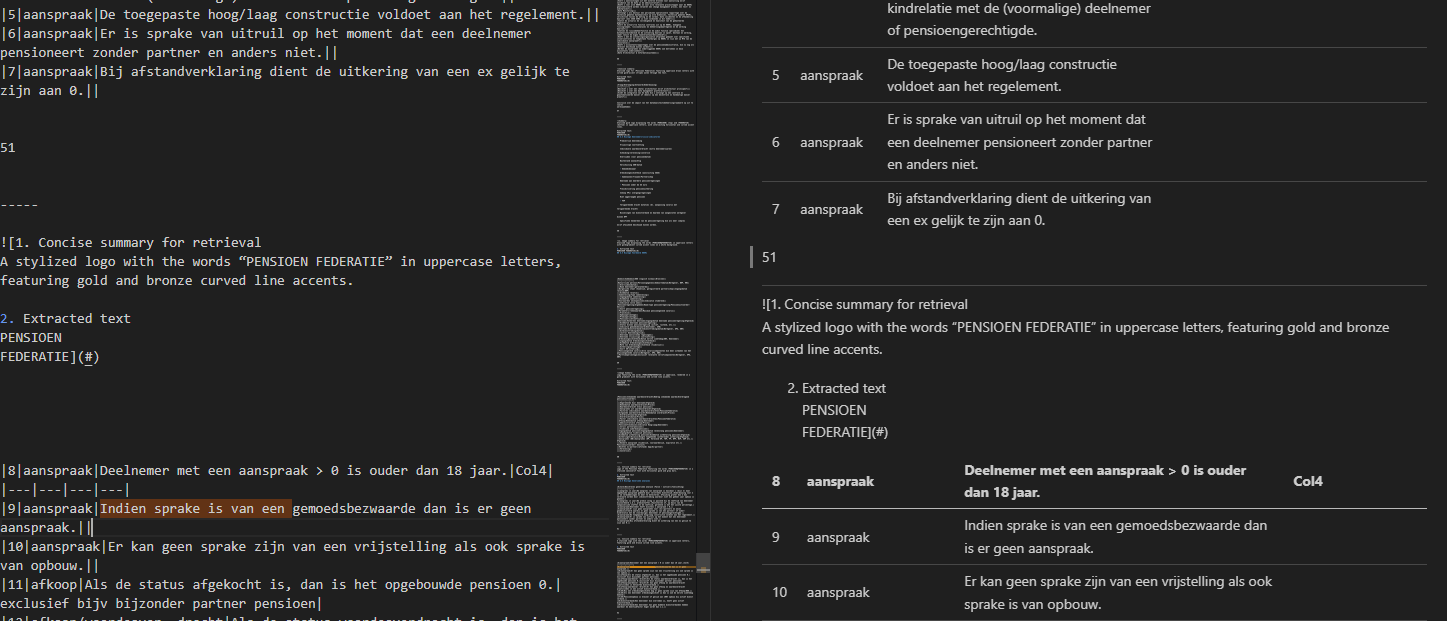

### Textsplitters

#### Using basic textsplitter on pagened documents

#### Using markdown textsplitter on single document

# Improvements on markdown

In [9]:
import pickle
import os
# load in document objects
SAVE_DIRECTORY = os.path.join("data", "intermediate-save")

# You must replace this with the actual filename from the save step
filename_to_load = "solvency-II-files-docs-2025-07-16_18-04-58.pkl"
filepath_to_load = os.path.join(SAVE_DIRECTORY, filename_to_load)

with open(filepath_to_load, 'rb') as f:
    loaded_docs = pickle.load(f)


# reasoning for mode = single is because of markdowntextsplitter used, therefore each page is the entire document
# save pdf documents which are transformed in markdown format with mode = "single" to seperate files 
for file_name, pages in loaded_docs.items():
    if len(pages) == 1: #only for single pages returned
        document = pages[0] #very prone to bugs, must be a better way
        loaded_docs[file_name] = document
    else:
        raise Exception("not implemented yet")
    

    # with open(os.path.join("data", "preprocessed", PROJECT_NAME, file_name + ".md"), 'w', encoding='utf-8') as f:
    #     f.write(document.page_content)

print(f"Successfully loaded {len(loaded_docs)} documents from {filepath_to_load}")
# ... proceed with your splitting logic

Successfully loaded 23 documents from data\intermediate-save\solvency-II-files-docs-2025-07-16_18-04-58.pkl


## Update Document Metadata

In [10]:
# clean up the headers, clean up the images

# adding additional metadata to the document
def get_short_title(filename: str):
    filename_to_short_title = {
    "Consolidated_GLs_CBs_ET_EN.pdf": "CB Guidelines (Consolidated)",
    "EIOPA-BoS-14-259_Final report_ORSA.pdf": "ORSA Final Report",
    "Guidelines on basis risk.pdf": "Basis Risk Guidelines",
    "Guidelines on Classification of Own Funds.pdf": "Own Funds Classification",
    "Guidelines on group solvency.pdf": "Group Solvency Guidelines",
    "Guidelines on health catastrophe risk sub-module.pdf": "Health Cat Risk Guidelines",
    "Guidelines on look-through approach.pdf": "Look-through Approach",
    "Guidelines on operational functioning of colleges.pdf": "Colleges Operational Guidelines",
    "Guidelines on Own Risk Solvency Assessment .pdf": "ORSA Guidelines",
    "Guidelines on reporting and public disclosure.pdf": "Reporting & Disclosure Guidelines",
    "Guidelines on ring-fenced funds.pdf": "Ring-fenced Funds Guidelines",
    "Guidelines on supervisory review process.pdf": "Supervisory Review Guidelines",
    "Guidelines on the use of internal models.pdf": "Internal Models Guidelines",
    "Guidelines on undertaking-specific parameters.pdf": "USP Guidelines",
    "JC 2024-34_Guidelines on costs and losses_DORA.pdf": "DORA Costs & Losses Guidelines",
    "Joint ESA Final Report on Art 97 Guidelines MiCAR.pdf": "MiCAR Art. 97 Final Report",
    "Joint ESA Gls MiCAR %28JC 2024 28%29_EN.pdf": "MiCAR Joint Guidelines (JC 2024/28)",
    "Joint Guidelines on Risk Factors.pdf": "Risk Factors Guidelines",
    "Privacy Statement - ESAs Information System.pdf": "ESA Privacy Statement",
    "Revised Guidelines on Contract Boundaries.pdf": "CB Guidelines (Revised)",
    "Technical Annexes.pdf": "Technical Annexes",
    "solvency II - level 1 - v2.pdf": "Solvency II – Level 1 Directive",
    "solvency II - level 2.pdf": "Solvency II – Level 2 Regulation"
    }
    if not filename in filename_to_short_title:
        print(f"[Warning] No short title found for {filename}")
        raise Exception("Please include filename: short_title")
    
    return filename_to_short_title[filename]

# replace page delimiter with page number + page delimiter

for filename, original_doc in loaded_docs.items():
    # short_title
    original_doc.metadata["short_title"] = get_short_title(original_doc.metadata["source"].split("\\")[-1])
    # document_id
    # source_type / level
    # document description
    # language?
    # preprocessing description
    # importance_score
    # entities
    # jurisdiction
    # topics
    # 


    # chunks:
    # legal_referencesh --> also verifies if markdown_splitter works correctly

## Substep 1 - Remove Headings and Footers

In [12]:
import re
def preprocess_markdown(text: str) -> str:
    """
    Converts the structured text of the EU Directive into a proper Markdown format
    that the ExperimentalMarkdownSyntaxTextSplitter can understand.
    """

    # LOGO removal or looking at images at least.
    # TOBEIMPLEMENTED
    # # remove any logo image from the markdown, to allow for better readability of tables
    # import re
    # directory = os.path.join("data", "preprocessed", PROJECT_NAME)
    # new_directory =  os.path.join("data", "preprocessed-v2", PROJECT_NAME)
    # for file_name in os.listdir(directory):
        # with open(os.path.join(directory, file_name), "r", encoding='utf-8') as f:
            # page_content = f.read()
    logo_regex = r"(?i)!\[([^\]]*?logo[^\]]*?)\]\(.*?\)" # case insenstive match for logo in summary
    # new_page_content = re.sub(regex, "", page_content)
    (processed_text, num_logo) = re.subn(logo_regex, "", text)
    print(f"Removed {num_logo} logo images from the text")
        # with open(os.path.join(new_directory, file_name), "w", encoding='utf-8') as f_new:
        #     f_new.write(new_page_content)

    # Solvency II Level 1 Directive Headers
    # remove headers

    # rewrite this part of the regex
    (processed_text, num_header_page)  = re.subn(r'^L \d{3}/\d{1,3} EN$\n{0,2}', '', processed_text, flags=re.MULTILINE)
    print(f"Removed {num_header_page} header pages")
    (processed_text, num_header_title) = re.subn(r'^Official Journ al of the E uropean Un ion.*?L \d+/\d+$\n{0,2}', '', processed_text, flags=re.MULTILINE)
    # print(f"Removed {num_header_title} header titles")
    (processed_text, num_header_title_2) = re.subn(r'^Official Journ al of the E uropean Un ion.*?\d+\.\d+\.\d+$\n{0,2}', '', processed_text, flags=re.MULTILINE)
    print(f"Removed {num_header_title + num_header_title_2} header titles in LEVEL 1")

    (processed_text, num_header_title_3) = re.subn(r'^11\.72\.2009\sEN$\n{0,2}', '', processed_text, flags=re.MULTILINE)
    print(f"Removed {num_header_title_3} header titles")

    (processed_text, num_header_title_4) = re.subn(r'^\d+\.\d+\.\d+ E N Official Journ al of the E uropean Un ion.*?L \d+/\d+$\n{0,2}', '', processed_text, flags=re.MULTILINE)
    (processed_text, num_header_title_4) = re.subn(r'}^L \d+/\d+ E N Official Journ al of the E uropean Un ion.*?\d+\.\d+\.\d+$\n{0,2}', '', processed_text, flags=re.MULTILINE)

    # Solvency II Level 2 Directive Headers
    # remove headers
    (processed_text, num_header_title) = re.subn(r'^\d+\.\d+\.\d+ EN Official Journal of the European Union.*?L \d+/\d+$\n{0,2}', '', processed_text, flags=re.MULTILINE)
    (processed_text, num_header_title_2) = re.subn(r'^L \d+/\d+ EN Official Journal of the European Union.*?\d+\.\d+\.\d+$\n{0,2}', '', processed_text, flags=re.MULTILINE)
    print(f"Removed {num_header_title + num_header_title_2} header titles in LEVEL 2")

    # used in some guidelines
    (processed_text, number_of_page_footers)= re.subn("\n(Page \d+/\d+)\n{0,2}", "", processed_text)
    (processed_text, number_of_page_footers_2) = re.subn("\n\d+/\d+\n{0,2}", "", processed_text)
    print(f"Removed {number_of_page_footers + number_of_page_footers_2} page footers")

    # Normalize italicized Articles to a consistent format for regex
    # (processed_text, num_articles_reformated) = re.subn(r'^\*(Article\s+\d+[a-z]?)\*$', r'\1', processed_text, flags=re.MULTILINE)
    # print(f"Reformatted {num_articles_reformated} italicized Articles to a consistent format")
    # Convert structural elements to Markdown headers.
    # The order of these rules is important.
    # https://www.oreilly.com/library/view/regular-expressions-cookbook/9780596802837/ch06s09.html
    roman_numerals = "(?=[MDCLXVI])M*(C[MD]|D?C{0,3})(X[CL]|L?X{0,3})(I[XV]|V?I{0,3})"
    replacements = [
        # Match "TITLE I", "TITLE IV", etc.
        (r"^(TITLE\s+" + roman_numerals + ")$", r"# \1"),
        # Match "CHAPTER I", "CHAPTER IX", etc.
        (r"^(\*?CHAPTER\s+(" + roman_numerals + ")\*?)$", r"## *CHAPTER \2*"),
        # Match "SECTION 1", "SECTION 5", etc.
        (r"^\*{0,1}((S e c t i o n|SECTION)\s+(\d+))\*{0,1}$", r"### Section \3"),
        # Match "Subsection 1", "Subsection 2", etc.
        (r"^((S u b s e c t i o n|Sub section|Subsection)\s+(\d+))$", r"#### Subsection \3"),
        # Match "Article 1", "Article 17a", etc.
        (r"^\*(Article\s+\d+[a-z]?)\*$", r"##### \1"),
    ]

    annex_replacements = [
        (r"^(\*ANNEX\s+" + roman_numerals + "\*)", r"# \1"),
    ]

    # level 3 guidelines --> relaxed regex for edge case:
    # **Guideline** **26** **-** **Impact** **of** **market-wide** **risks** **and** **financial** **sector**
    # **developments on prudential supervision**
    # upgrade to level 4 header, as in certain case is level 3, and certain case level 4.
    guidelines_replacements = [
        (r"^(\*{0,2}Guideline.*\d+.*\*{0,2}.*)$", r"#### \1"),
    ]

    replacements.extend(annex_replacements)
    replacements.extend(guidelines_replacements)

    # make section one format

    for pattern, replacement in replacements:
        (processed_text, number) = re.subn(pattern, replacement, processed_text, flags=re.MULTILINE)
        print(f"Replaced {number} occurrences of pattern '{pattern}' with '{replacement}'")

    return processed_text


for file_name in loaded_docs.keys():
    processed_text = preprocess_markdown(loaded_docs[file_name].page_content)
    loaded_docs[file_name].page_content = processed_text

# file_name = "solvency II - level 1 - v2.pdf"
# processed_text = preprocess_text_to_markdown(text=loaded_docs[file_name].page_content)
    if file_name == "solvency II - level 1 - v2.pdf" or file_name == "EIOPA-BoS-14-259_Final report_ORSA.pdf":
        with open(os.path.join("data", "preprocessed-step-2", PROJECT_NAME, "substep-1-" + file_name + ".md"), 'w', encoding='utf-8') as f:
            f.write(processed_text)
    if file_name == "solvency II - level 2.pdf":
        with open(os.path.join("data", "preprocessed-step-2", PROJECT_NAME, "substep-1-" + file_name + ".md"), 'w', encoding='utf-8') as f:
            f.write(processed_text)

# still to do: need to get SECTION working, some of the text disappears.
# remove the toc before splitting

<>:48: SyntaxWarning: invalid escape sequence '\d'
<>:49: SyntaxWarning: invalid escape sequence '\d'
<>:63: SyntaxWarning: invalid escape sequence '\*'
<>:73: SyntaxWarning: invalid escape sequence '\*'
<>:48: SyntaxWarning: invalid escape sequence '\d'
<>:49: SyntaxWarning: invalid escape sequence '\d'
<>:63: SyntaxWarning: invalid escape sequence '\*'
<>:73: SyntaxWarning: invalid escape sequence '\*'
C:\Users\bvbraak\AppData\Local\Temp\ipykernel_19600\2457999022.py:48: SyntaxWarning: invalid escape sequence '\d'
  (processed_text, number_of_page_footers)= re.subn("\n(Page \d+/\d+)\n{0,2}", "", processed_text)
C:\Users\bvbraak\AppData\Local\Temp\ipykernel_19600\2457999022.py:49: SyntaxWarning: invalid escape sequence '\d'
  (processed_text, number_of_page_footers_2) = re.subn("\n\d+/\d+\n{0,2}", "", processed_text)
C:\Users\bvbraak\AppData\Local\Temp\ipykernel_19600\2457999022.py:63: SyntaxWarning: invalid escape sequence '\*'
  (r"^(\*?CHAPTER\s+(" + roman_numerals + ")\*?)$", r"##

Removed 0 logo images from the text
Removed 0 header pages
Removed 0 header titles in LEVEL 1
Removed 0 header titles
Removed 0 header titles in LEVEL 2
Removed 0 page footers
Replaced 0 occurrences of pattern '^(TITLE\s+(?=[MDCLXVI])M*(C[MD]|D?C{0,3})(X[CL]|L?X{0,3})(I[XV]|V?I{0,3}))$' with '# \1'
Replaced 0 occurrences of pattern '^(\*?CHAPTER\s+((?=[MDCLXVI])M*(C[MD]|D?C{0,3})(X[CL]|L?X{0,3})(I[XV]|V?I{0,3}))\*?)$' with '## *CHAPTER \2*'
Replaced 0 occurrences of pattern '^\*{0,1}((S e c t i o n|SECTION)\s+(\d+))\*{0,1}$' with '### Section \3'
Replaced 0 occurrences of pattern '^((S u b s e c t i o n|Sub section|Subsection)\s+(\d+))$' with '#### Subsection \3'
Replaced 0 occurrences of pattern '^\*(Article\s+\d+[a-z]?)\*$' with '##### \1'
Replaced 0 occurrences of pattern '^(\*ANNEX\s+(?=[MDCLXVI])M*(C[MD]|D?C{0,3})(X[CL]|L?X{0,3})(I[XV]|V?I{0,3})\*)' with '# \1'
Replaced 0 occurrences of pattern '^(\*{0,2}Guideline.*\d+.*\*{0,2}.*)$' with '#### \1'
Removed 0 logo images from the te

## Substep 2 - Change page delimiter to contain page numbers

In [13]:
import re
from langchain_core.documents import Document
def create_page_replacer(start_page=1):
    """
    A closure to create a stateful replacer function.
    """
    page_counter = start_page + 1 # First page does not have a delimiter
    def replacer(match):
        nonlocal page_counter
        # Format the page number string however you like
        replacement_text = f"\n--- Page {page_counter} ---\n"
        page_counter += 1
        return replacement_text
    return replacer

def preprocess_page_numbers(document: Document) -> str:
    # _DEFAULT_PAGES_DELIMITER = r"\n-----\n\n"
    _ADJUSTED_DEFAULT_PAGES_DELIMITER = r"\n*\n-----\n\n\n*"
    page_delimiters = re.findall(_ADJUSTED_DEFAULT_PAGES_DELIMITER, document.page_content)
    checksum = document.metadata["total_pages"] - 1 == len(page_delimiters)


    
    if not checksum:
        raise Exception("Number of page delimiters does not match total pages in metadata")
    
    (processed_text, num_page_separators)  = re.subn(r'' + _ADJUSTED_DEFAULT_PAGES_DELIMITER, create_page_replacer(), document.page_content) # Replace page breaks with paragraph breaks
    print(f"Replaced {num_page_separators} page separators")


    processed_text = "\n--- Page 1 ---\n" + processed_text

    return processed_text

# file_name = "solvency II - level 1 - v2.pdf"

for file_name in loaded_docs.keys():
    processed_text = preprocess_page_numbers(loaded_docs[file_name])
    loaded_docs[file_name].page_content = processed_text

    if file_name == "solvency II - level 1 - v2.pdf":
        with open(os.path.join("data", "preprocessed-step-2", PROJECT_NAME, "substep-2-" + file_name + ".md"), 'w', encoding='utf-8') as f:
            f.write(processed_text)
    if file_name == "solvency II - level 2.pdf":
        with open(os.path.join("data", "preprocessed-step-2", PROJECT_NAME, "substep-2-" + file_name + ".md"), 'w', encoding='utf-8') as f:
            f.write(processed_text)
# print(type(create_page_replacer()))

Replaced 17 page separators
Replaced 31 page separators
Replaced 3 page separators
Replaced 20 page separators
Replaced 14 page separators
Replaced 6 page separators
Replaced 4 page separators
Replaced 37 page separators
Replaced 7 page separators
Replaced 17 page separators
Replaced 12 page separators
Replaced 13 page separators
Replaced 25 page separators
Replaced 6 page separators
Replaced 5 page separators
Replaced 47 page separators
Replaced 21 page separators
Replaced 72 page separators
Replaced 5 page separators
Replaced 4 page separators
Replaced 11 page separators
Replaced 154 page separators
Replaced 796 page separators


## Substep 3 - PDF to Markdown conversion mistakes in level 1

In [14]:
# article headers are misplaced, in cases where in the two column set-up both an article starts at the left top and right top
# example is page L 335/47 Article 81 and Article 82

# list of articles suffering from this pdf --> .md conversion problem

# solvency II level 1 - v2.pdf.md
solvency_level_1_headers_problematic = [
    {"misplaced_header": "##### Article 84", "header_description": "**Appropriateness of the level of technical provisions**"}, # "#### Article 82", "#### Article 85", 
    {"misplaced_header": "##### Article 174", "header_description": "**Principle and conditions for conducting reinsurance**\n**activity**"}, # "#### Article 172", "#### Article 175", 
    {"misplaced_header": '### Section 5\n\n\n**Exception to the free choice of lawyer**', "header_description": "**H e a l t h i n s ur a n c e**"}, #203, # Article 203 and Section 5 header problem.
    {"misplaced_header": "### Section 5\n\n\n**C o n d i t i o n s o f i n s ur a n c e c o n t r a c t s a n d**", "header_description": "**I n f o r m a t i o n f o r p o l i c y h o l d e r s**"},
    {"misplaced_header": "##### Article 266", "header_description": "**Cooperation with third countries**"}, # "#### Article 265", "#### Article 267", 
    {"misplaced_header": "##### Article 281", "header_description": "**Information to known creditors**"} # "#### Article 279", "#### Article 282"
]

file_name = "solvency II - level 1 - v2.pdf"
# processed_text = preprocess_text_to_markdown()
processed_text=loaded_docs[file_name].page_content

# text = """Article 301(3).

# ### Section 5
# """

for header_problem in solvency_level_1_headers_problematic:
    (processed_text, count) = re.subn(re.escape(header_problem["misplaced_header"]), "", processed_text)
    if count != 1:
        raise Exception(f"Expected to find exactly one misplaced header, found {count} for {header_problem['misplaced_header']}")
    print(f"Removed {count} misplaced header: {header_problem['misplaced_header']}")
    replacement_text = header_problem["misplaced_header"] + "\n\n" + header_problem["header_description"]
    if header_problem["header_description"] == "**H e a l t h i n s ur a n c e**":
        # quick hack
        replacement_text = "### Section 5" + "\n\n" + "**H e a l t h i n s ur a n c e**"
    elif header_problem["misplaced_header"] == "**I n f o r m a t i o n f o r p o l i c y h o l d e r s**":
        replacement_text = "### Section 5" + "\n\n" + "**I n f o r m a t i o n f o r p o l i c y h o l d e r s**"
    
    (processed_text, count) = re.subn(re.escape(header_problem["header_description"]), replacement_text, processed_text)
    if count != 1:
        raise Exception(f"Expected to find exactly one header description, found {count} for {header_problem['header_description']}")
    
with open(os.path.join("data", "preprocessed-step-2", PROJECT_NAME, "substep-3-" + file_name + ".md"), 'w', encoding='utf-8') as f:
    f.write(processed_text)


# overwite the page content
loaded_docs[file_name].page_content = processed_text

Removed 1 misplaced header: ##### Article 84
Removed 1 misplaced header: ##### Article 174
Removed 1 misplaced header: ### Section 5


**Exception to the free choice of lawyer**
Removed 1 misplaced header: ### Section 5


**C o n d i t i o n s o f i n s ur a n c e c o n t r a c t s a n d**
Removed 1 misplaced header: ##### Article 266
Removed 1 misplaced header: ##### Article 281


## Substep 4 - Drop TOC for level 1 and level 2

In [15]:
structure_solvency_II_level_1 = {
    "file_name": "solvency II - level 1 - v2.pdf",
    "toc": (14, 17),
    "recitals": (1, 13),
    "CORRELATION_TABLES": (131, 155), 
    "NUM_TITLES": 6,
    "NUM_CHAPTERS": 25,
    "NUM_SECTIONS": 41,
    "NUM_SUBSECTIONS": 22,
    "NUM_ARTICLES": 312
}

structure_solvency_II_level_2 ={
  "file_name": "solvency II - level 2.pdf",
  "toc": (1, 4),
  "recitals": (5, 20),
  "CORRELATION_TABLES": (296, 797),
  "NUM_TITLES": 3,
  "NUM_CHAPTERS": 25,
  "NUM_SECTIONS": 61,
  "NUM_SUBSECTIONS": 31,
  "NUM_ARTICLES": 381
}

structures = [structure_solvency_II_level_1, structure_solvency_II_level_2]

In [16]:
# step 4 drop toc of solvency II
import re

for structure in structures:
    file_name = structure["file_name"]
    # processed_text = preprocess_text_to_markdown()
    processed_text=loaded_docs[file_name].page_content

    start_toc = structure["toc"][0]
    end_toc = structure["toc"][1] + 1 # last_page
    (processed_text, number_toc) = re.subn(r"--- Page " + str(start_toc) + " ---.*?(--- Page " + str(end_toc) + " ---)",r"\1", processed_text, flags=re.DOTALL)
    if number_toc:
        # toc = match.group(1).strip()
        print(f"Removed {number_toc} TOC pages from the document {file_name}")
        # print(toc)

    with open(os.path.join("data", "preprocessed-step-2", PROJECT_NAME, "substep-4-" + file_name + ".md"), 'w', encoding='utf-8') as f:
        f.write(processed_text)

    # overwite the page content
    loaded_docs[file_name].page_content = processed_text

Removed 1 TOC pages from the document solvency II - level 1 - v2.pdf
Removed 1 TOC pages from the document solvency II - level 2.pdf


## Substep 5 - Drop Correlation Tables

In [17]:
for structure in structures:
    file_name = structure["file_name"]
    # processed_text = preprocess_text_to_markdown()
    processed_text=loaded_docs[file_name].page_content

    correlation_tables_start = structure["CORRELATION_TABLES"][0]
    # correlation_tables_end = # structure_solvency_II_level_1["annexes VII - CORRELATION TABLES"][1] #page is end of document

    (processed_text, correlation_tables_annex) = re.subn(r"--- Page " + str(correlation_tables_start) + " ---.*","", processed_text, flags=re.DOTALL)
    if correlation_tables_annex:
        print(f"Removed {correlation_tables_annex} Annex pages from {file_name}")

    with open(os.path.join("data", "preprocessed-step-2", PROJECT_NAME, "substep-5-" + file_name + ".md"), 'w', encoding='utf-8') as f:
        f.write(processed_text)

    loaded_docs[file_name].page_content = processed_text

Removed 1 Annex pages from solvency II - level 1 - v2.pdf
Removed 1 Annex pages from solvency II - level 2.pdf


## Substep 6 - Equations

In [ ]:
# WARNING THIS IS AI SLOP
import pymupdf
import collections
import re
import os

WEAK_MATH_SYMBOLS = {'×', '+', '−'}
STRONG_MATH_SYMBOLS = {'√', '∑', '=', '¼', '∂', '∫', '≥', '≤', '≠', '�', 'Þ'}

SCORING_WEIGHTS = {
    'is_strong_math_symbol': 15,
    'is_weak_math_symbol': 3,
    'is_large_symbol': 3,
    'is_subscript': 3,
    'is_superscript': 3,
    'is_italic': 1,
    'is_largely_alphabetic': 5
}

LINE_SCORE_THRESHOLD = 9


def merge_bboxes(bboxes):
    """Merges a list of bounding boxes into a single bounding box."""
    if not bboxes:
        return None
    min_x0 = min(b[0] for b in bboxes)
    min_y0 = min(b[1] for b in bboxes)
    max_x1 = max(b[2] for b in bboxes)
    max_y1 = max(b[3] for b in bboxes)
    return pymupdf.Rect(min_x0, min_y0, max_x1, max_y1)

def bbox_distance(box1, box2):
    """Calculates the Euclidean distance between the centers of two bounding boxes."""
    x1, y1 = (box1[0] + box1[2]) / 2, (box1[1] + box1[3]) / 2
    x2, y2 = (box2[0] + box2[2]) / 2, (box2[1] + box2[3]) / 2
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

def get_dominant_line_properties(line):
    """Calculates the most common font size and baseline for a line."""
    if not line['spans']:
        return 0, 0, False
        
    baselines = [round(s['bbox'][3], 2) for s in line['spans']]
    sizes = [round(s['size'], 2) for s in line['spans']]
    fonts = [s['font'] for s in line['spans']]
    
    dominant_size = collections.Counter(sizes).most_common(1)[0][0]
    dominant_baseline = collections.Counter(baselines).most_common(1)[0][0]
    is_bold_dominant = 'Bold' in collections.Counter(fonts).most_common(1)[0][0]

    return dominant_size, dominant_baseline, is_bold_dominant

def is_likely_heading_or_prose(line, is_bold_dominant):
    """
    Applies negative heuristics to determine if a line is likely a heading or regular text.
    """
    full_text = "".join(span['text'] for span in line['spans']).strip()
    
    if not full_text:
        return False

    # Heuristic 1: Starts with a number like "1." or "A."
    if re.match(r'^[\[\(]?\d{1,2}[\.\)]', full_text):
        return True

    # Heuristic 2: Line is dominantly bold.
    if is_bold_dominant:
        return True

    # Heuristic 3: High ratio of letters to other characters.
    # Equations have a low ratio of letters.
    text_no_space = full_text.replace(" ", "")
    if not text_no_space:
        return False # Empty line
        
    alpha_chars = sum(1 for char in text_no_space if char.isascii()) #changed is isascii
    total_chars = len(text_no_space)
    alpha_ratio = alpha_chars / total_chars
    
    # If over 90% of characters are letters, it's likely prose/heading.
    if alpha_ratio > 0.90:
        return True
    
    # print(alpha_ratio)
        
    return False


def calculate_positive_line_score(line, dominant_size, dominant_baseline):
    line_score = 0
    for span in line['spans']:
                if any(char in WEAK_MATH_SYMBOLS for char in span['text']):
                    line_score += SCORING_WEIGHTS['is_weak_math_symbol']
                if any(char in STRONG_MATH_SYMBOLS for char in span['text']):
                    line_score += SCORING_WEIGHTS['is_strong_math_symbol']
                if 'Italic' in span['font']:
                    line_score += SCORING_WEIGHTS['is_italic']
                
                height = span['bbox'][3] - span['bbox'][1]
                if height > dominant_size * 1.5:
                    line_score += SCORING_WEIGHTS['is_large_symbol']
                
                is_smaller = span['size'] < dominant_size * 0.9
                span_baseline = span['bbox'][3]
                
                if is_smaller and span_baseline > dominant_baseline + 1:
                    line_score += SCORING_WEIGHTS['is_subscript']
                if is_smaller and span_baseline < dominant_baseline - 2:
                    line_score += SCORING_WEIGHTS['is_superscript']

    return line_score

# This is the new helper function
def expand_cluster_to_include_neighbors(cluster, all_page_lines):
    """
    Expands a given cluster by searching for and including adjacent lines.

    Args:
        cluster (list): A list of line dictionaries forming the initial cluster.
        all_page_lines (list): All line dictionaries from the page.
        threshold_ratio (float): How close a line must be to be considered a neighbor,
                                 as a ratio of its own height.
    
    Returns:
        list: The expanded cluster including any new neighbor lines.
    """
    # Use a set of tuple-ized bboxes for quick lookup of lines already in the cluster
    cluster_line_ids = {tuple(line['bbox']) for line in cluster}
    
    # Use a while loop to repeatedly expand until no new neighbors are found

    # Define search radius based on the current span's height
    cluster_bbox = merge_bboxes([line['bbox'] for line in cluster])

    # non-recursive search
    THRESHOLD = 0.5
    MARGIN_CAP = 10
    inflation_margin = cluster_bbox.height * THRESHOLD if cluster_bbox.height * THRESHOLD < MARGIN_CAP else MARGIN_CAP
    # print(inflation_margin)

    # define inflated search bbox
    X_INFLATED = 100
    Y_INFLATED = 2

    inflated_search_bbox = pymupdf.Rect(cluster_bbox.x0 - X_INFLATED,cluster_bbox.y0 - Y_INFLATED, cluster_bbox.x1 + X_INFLATED, cluster_bbox.y1 + Y_INFLATED)
    # print(f"{inflated_search_bbox} vs {cluster_bbox}")

    for line in all_page_lines:
        for other_span in line['spans']: 
            # print(f"Inspecting span {other_span['text']} for cluster {cluster} ")
            if other_span['bbox'] in cluster_line_ids:
                # print("skipping in span")
                continue
            # if other_span['visited']:
            #     continue
            # if bbox_distance(inflated_search_bbox, other_span['bbox']) > 0:
            #     print(f"skipping out of bbox, {bbox_distance(inflated_search_bbox, other_span['bbox'])}")
            #     continue
            
            if inflated_search_bbox.intersects(other_span['bbox']):
                # print(f'Intersection found between {inflated_search_bbox} and {other_span['bbox']}')
                
                # add to cluster
                cluster.append(line)
                break

                # included in another cluster
                # other_span['visited'] = True
            
    return cluster

    

def detect_equations(page_data, verbose=0):
    """
    Detects equations from a page's text dictionary representation.
    """
    math_lines = []
    
    for block in page_data.get('blocks', []):
        if block.get('type', 0) != 0:
            continue
            
        for line in block.get('lines', []):
            dominant_size, dominant_baseline, is_bold_dominant = get_dominant_line_properties(line)

            if dominant_size == 0:
                continue

            line_score = calculate_positive_line_score(line, dominant_size, dominant_baseline)

            # Check if the line matches heading/prose characteristics.
            if is_likely_heading_or_prose(line, is_bold_dominant):
                line_score -= SCORING_WEIGHTS['is_largely_alphabetic']

            if verbose:
                print(f"Processing line: {[span['text'] for span in line['spans']]} with score {line_score}")

            if line_score >= LINE_SCORE_THRESHOLD:

                math_lines.append({
                    'score': line_score,
                    'bbox': line['bbox'],
                    'spans': line['spans']
                })

    if not math_lines:
        return []

    math_lines.sort(key=lambda l: l['bbox'][1])
    clusters = []
    current_cluster = [math_lines[0]]
    
    for i in range(1, len(math_lines)):
        prev_line = current_cluster[-1]
        current_line = math_lines[i]
        vertical_gap = current_line['bbox'][1] - prev_line['bbox'][3]
        prev_line_height = prev_line['bbox'][3] - prev_line['bbox'][1]
        
        if vertical_gap < prev_line_height * 0.5:
            current_cluster.append(current_line)
        else:
            clusters.append(current_cluster)
            current_cluster = [current_line]
            
    clusters.append(current_cluster)

    all_page_lines = []
    for block in page_data.get('blocks', []):
        all_page_lines += [line for line in block.get('lines', [])]
    expanded_clusters = []

    for cluster in clusters:
        expanded_cluster = expand_cluster_to_include_neighbors(cluster, all_page_lines)
        expanded_clusters.append(expanded_cluster)
        print(f"Expanded cluster with {len(expanded_cluster)} lines, original size: {len(cluster)}") if verbose else None

    print(f"Found {expanded_clusters} clusters.") if verbose else None

    
    detected_equations = []
    for expanded_cluster in expanded_clusters:
        print(f"Expanded cluster spans: {expanded_cluster}") if verbose else None
        # all_spans = [span for line in cluster for span in line['spans']]
        all_spans = [span for line in expanded_cluster for span in line['spans']]
        cluster_bbox = merge_bboxes([line['bbox'] for line in expanded_cluster])
        detected_equations.append({
            'bbox': cluster_bbox,
            'spans': all_spans
        })

    

    return detected_equations


def print_equations(equations):
    print(f"Detected {len(equations)} equations.\n")
    
    for i, eq in enumerate(equations):
        eq_text = "".join([s['text'] for s in eq['spans']])

        print([s['text'] for s in eq['spans']])
        print(f"--- Equation {i+1} ---")
        print(f"  Bounding Box: {eq['bbox']}")
        print(f"  Reconstructed Text: {eq_text}")
        print("-" * 20 + "\n")

with open(os.path.join("data", "raw", "solvency-II-files", "solvency II - level 2.pdf"), 'rb') as f:
    original_doc = pymupdf.open(f)

# page_number = 70

# equations = detect_equations(original_doc[page_number - 1].get_text("dict", flags=0), verbose=1)

# print(f"File: {filename}")
# print_equations(equations)

In [228]:
file_name = "solvency II - level 1 - v2.pdf"
from pymupdf import mupdf

with open(os.path.join("data", "raw", "solvency-II-files", f"{file_name}"), 'rb') as f:
    original_doc = pymupdf.open(f) # detection on original pdf
    
markdown_file = loaded_docs[file_name].page_content

for page in [original_doc[124]]: 
    page_text_in_dict = page.get_text("dict", flags=0) #sort=True)
    # print(get_page_spans(page_text_in_dict)[0]['bbox'])
    equations_detected = detect_equations(page_text_in_dict, verbose=0)

    textflags = (
        0
        | mupdf.FZ_STEXT_CLIP
        | mupdf.FZ_STEXT_ACCURATE_BBOXES
        # | mupdf.FZ_STEXT_IGNORE_ACTUALTEXT
        | 32768  # mupdf.FZ_STEXT_COLLECT_STYLES
    )

    textpage = page.get_textpage(flags=textflags)
    for idx, block in enumerate(textpage.extractBLOCKS()):
        print(f"block {idx}: ", block)

    # for idx, block in enumerate(page.get_text("blocks", flags=0, sort=True)): #page_text_in_dict.get('blocks', []):
    #     print(f"block {idx}: ", block)
    
    # for idx, text in enumerate(page.get_text("words", sort=True)):
    #     print(f"text {idx}: ", text)

    # for equation in equations_detected:
    #     print(f"Equation Bounding Box: {equation['bbox']}")
    #     equation_text = [span['text'] for span in equation['spans'] if span['text'].strip() != '']
    #     print(equation_text)


block 0:  (41.306400299072266, 50.32911682128906, 552.9212646484375, 60.005889892578125, '17.12.2009\nEN\nOfficial Journal of the European Union\nL 335/125\n', 0, 0)
block 1:  (92.4660873413086, 75.79660034179688, 279.9916076660156, 84.61046600341797, '3. Calculation of the life underwriting risk module\n', 1, 0)
block 2:  (105.25598907470703, 98.34961700439453, 408.0696716308594, 106.99279022216797, 'The life underwriting risk module set out in Article 105(3) shall be equal to the following:\n', 2, 0)
block 3:  (105.25076293945312, 163.7619171142578, 503.3428955078125, 191.58990478515625, 'where SCRi denotes the sub-module i and SCRj denotes the sub-module j, and where ‘i,j’ means that the sum of the dif\xad\nferent terms should cover all possible combinations of i and j. In the calculation, SCRi and SCRj are replaced by the \nfollowing:\n', 3, 0)
block 4:  (105.25343322753906, 205.32911682128906, 296.2548828125, 215.19810485839844, '—\nSCR mortality denotes the mortality risk sub-mod

In [20]:
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
import base64
from langchain_core.messages import HumanMessage
import os

load_dotenv()

llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-pro", 
        api_key=os.environ["GOOGLE_API_KEY"], 
        temperature=0.2,
)


# test_image = f"data/raw/test-data/solvency_II_equations_page_{page.number + 1}.png"

def extract_equations(llm, image_url):
        # from docs: https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/image-understanding
        # * If you want to detect text in an image, use prompts with a single image to produce better results than prompts with multiple images.
        # * If your prompt contains a single image, place the image before the text prompt in your request.

        # from docs, may not be fully applicable but related:
        # For most accurate OCR results from Document AI, document scans should be a minimum of 200 dpi (dots per inch). 300 dpi and higher generally produce the best results. OCR accuracy is dependent on both the resolution and the minimum font size, along with other factors like document (and if handwritten, handwriting) quality, so testing is recommended. The image quality analysis feature can help evaluate resolution concerns.
        # we have precompute images where equation are detected for solvency level 2 at 400 dpi
        with open(image_url, "rb") as f:
                image_data = base64.b64encode(f.read()).decode("utf-8")
                extraction_prompt = "Extract equation(s) in latex from this page, only consider full equation, not inline reference to variable"
                format_examples = r"""
                \n# Example output format
                Here are the equations from the page, in LaTeX format:
```latex
\text{SCR}_{\text{earthquake}} = \sqrt{\left(\sum_{(r,s)} \text{CorrEQ}_{(r,s)} \cdot \text{SCR}_{(\text{earthquake},r)} \cdot \text{SCR}_{(\text{earthquake},s)}\right) + \text{SCR}^2_{(\text{earthquake,other})}}
```
```latex
\text{WSI}_{(\text{earthquake},r,i)} = W_{(\text{earthquake},r,i)} \cdot \text{SI}_{(\text{earthquake}, r,i)}
```
```latex
\text{SI}_{(\text{earthquake},r,i)} = \text{SI}_{(\text{property},r,i)} + \text{SI}_{(\text{onshore-property},r,i)}
```

                # Answer based on the provided image adhering to the example format
                """
                message = HumanMessage(
                content=[
                        {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/png;base64,{image_data}"},
                        },
                        {"type": "text", "text": extraction_prompt + format_examples},
                ]
                )
                # print("LLM INSTRUCTION")
                # pprint.pprint(message)
                response = llm.invoke([message])

        equations_converted = re.findall(r"```latex(.*?)```", response.text(), re.DOTALL)

        return equations_converted

# extract_equations(llm, test_image)

In [ ]:
# import pymupdf4llm
import os
import pprint
import time

regex_without_page = r"((following|follows)([^\n]*?:|\n))((?!following|follows).)*?(\n((where(((?!where).)*?(?=\(a\))))|where|provided))"
# example of page within (following|follows) ... where block --- Page 78 --- in solvency II - level 2
# regex_with_page = r'((following|follows)[^\n]*?:)((?!following|follows).)*?(--- Page \d+ ---)((?!following|follows).)*?(\n(where|provided))'

def find_equation_snippets(markdown_file):
    matches = re.finditer(regex_without_page, markdown_file, re.DOTALL)
    return [match.group(0) for match in matches]

def find_page(markdown_file, current_page_number, next_page_number, is_last_page):
    # print(f"Finding page {current_page_number} and {next_page_number} in markdown file. Is it last {is_last_page}")
    page_regex = r"(--- Page " + str(current_page_number) + " ---.*?)"
    if is_last_page:
        match = re.search(page_regex, markdown_file, re.DOTALL)
        return match.group(0)


    page_regex += r"(--- Page " + str(next_page_number) + " ---)(\nwhere)?"
    match = re.search(page_regex, markdown_file, re.DOTALL)
    if not match:
        raise Exception(f"Expected exactly one match for page {current_page_number}, found 0.")
    return match.group(1) + (match.group(3) + "\n" if match.group(3) else "")

def evaluate_placement_likelihood(ordered_equation_spans, snippets, verbose=0, std_output_file=None):
    count_per_snippet = [0] * len(snippets)
    count_in_expected_order = [0] * len(snippets)
    for i, snippet in enumerate(snippets):
        # snippet = snippet.replace(" ", "")
        # snippet = snippet.replace("*", "")
        snippet = snippet.replace("*", "").replace("[", "").replace("]", "").replace("\n", " ")
        snippet_chunks = snippet.split(" ")
        clean_snippet_chunks = []
        # remove empty chunks
        for snippet_chunk in snippet_chunks:
            if snippet_chunk != "":
                clean_snippet_chunks.append(snippet_chunk)

        clean_snippet = "".join(clean_snippet_chunks)
        clean_snippet = re.sub("following|follows|where", "", clean_snippet, flags=re.MULTILINE)

        if verbose:
            print(f"ordered equation_spans: {ordered_equation_spans}", file=std_output_file)
            print(f"evaluation for snippet {i}: {clean_snippet}", file=std_output_file)
        current_search_index = 0 # tries to take the order into account
        current_window_extra_size = 0


        for idx, span in enumerate(ordered_equation_spans):
            span = span.replace(" ", "")
            # set up found_pos and search_window
            snippet_window = []
            if idx == 0 or current_search_index == 0: # find first snippet with match
                # found_pos = snippet.find(span)
                try: 
                    found_pos = clean_snippet.index(span)
                except ValueError:
                    found_pos = -1
            else:
                # SEARCH_WINDOW = len(span) * 3 if len(span) * 3 < len(snippet) else len(span)
                # end = current_search_index + SEARCH_WINDOW + 1 + current_window_extra_size
                # end = min(end, len(snippet))  # Ensure we don't go out of bounds
                # found_pos = snippet.find(span, current_search_index, end)
                SEARCH_WINDOW = current_window_extra_size + current_window_extra_size + 3 if current_search_index + current_window_extra_size + 3 < len(clean_snippet) else len(clean_snippet)
                snippet_window = clean_snippet[current_search_index:current_search_index + SEARCH_WINDOW]
                try:
                    found_pos = current_search_index + snippet_window.index(span)
                except ValueError:
                    found_pos = -1
            if verbose:
                print(f"WINDOW {snippet_window} for {span}", file=std_output_file)
                if found_pos != -1:
                    print(f"Found '{span}' at position {found_pos} in snippet {i}.", file=std_output_file)

            # update score accordingly
            if span in clean_snippet:
                # print(f"Found '{span}' in snippet {i}.")
                count_per_snippet[i] += 1
                if found_pos != -1:
                    count_in_expected_order[i] += 1
                    current_search_index = found_pos + 1
                    current_window_extra_size = 0
                else:
                    current_window_extra_size += 1
    return count_per_snippet, count_in_expected_order


def convert_equations(best_matches, image_url):
    equations_converted = extract_equations(llm, image_url)

    if len(equations_converted) != len(best_matches):
        raise Exception("[Error in converting equations to latex]")
    
    for i, equation_converted in enumerate(equations_converted):
        first_match = next((best_match for best_match in best_matches if best_match["snippet"]["index"] == i), None)
        # print(f"equation_converted: {equation_converted}")
        first_match["equation"]["latex"] = equation_converted


def handle_replacement(best_matches, page_md, page_number):
    # print(f"\nHandling replacement for page {page_number} with {len(best_matches)} best matches.")
    i = 0
    number_replaced = 0

    def replacer(match: re.Match):
        # print("Found {} matches".format(len(matches)))

        nonlocal i
        nonlocal best_matches
        nonlocal number_replaced
        # is the snippet a best_match?
        first_match = next((best_match for best_match in best_matches if best_match["snippet"]["index"] == i), None)
        i += 1

        equation_latex_llm = first_match["equation"]["latex"] if first_match and "latex" in first_match["equation"] else ""

        if first_match:
            latex_equation = f"equation {equation_latex_llm} in snippet {first_match['snippet']['text']} replaced equation {first_match['equation']['text']}"
            number_replaced += 1

            # if not match.group(11):
                # match without page
            # print("Match without page: ", match.group(2), match.group(3))
            if match.group(7):
                return f"{match.group(1)}\n<REPLACEMENT_EQUATION>\n {latex_equation} \n</REPLACEMENT_EQUATION>\nwhere:\n(a)"
            return f"{match.group(1)}\n<REPLACEMENT_EQUATION>\n {latex_equation} \n</REPLACEMENT_EQUATION>\n{match.group(4)}\n"
        else:
            return match.group(0)

        
        # # replace equation

    # regex = "|".join([regex_without_page, regex_with_page])

    # page = response.text()
    # with open(os.path.join("data", "preprocessed-step-final", "solvency-II-files", "final_solvency II - level 2.pdf.md"), 'r', encoding="utf-8") as f:
    #     page = f.read()
    page_delimiter = "--- Page " + str(page_number) + " ---"

    page_delimiter_before = re.findall(page_delimiter, page_md)

    (processed_text, equation_replaced) = re.subn(regex_without_page, replacer, page_md, flags=re.DOTALL)
    # print(f"Replaced {equation_replaced} equations on page.")

    # verify replacement did not change number of page delimiters
    page_delimiter_after = re.findall(page_delimiter, processed_text)
    if page_delimiter_after != page_delimiter_before:
        print(f"[ERROR, PAGE DELIMITER CHANGED]: Before: {page_delimiter_before}, After: {page_delimiter_after}")
        raise Exception(f"Page delimiter on page: {page_number}")

    if number_replaced != len(best_matches):
        print(f"Expected {len(best_matches)} replacements, but got {number_replaced}.")
        raise Exception(f"[ERROR, REPLACEMENT NOT SUCCESSFULL] for {page_number}")

    return processed_text

def match_equations(original_doc, markdown_file, process_page_mask, file_name, std_output_file):
    # markdown_file = pymupdf4llm.to_markdown(doc)
    # markdown_file_with_equation_replaced = ""
    matches_per_page = []

    page_numbers_unresolved = []
    equation_matching_unresolved = []
    total_number_of_pages_with_equations = 0
    total_matches_not_accepted = 0
    total_equation_detected = 0
    total_equation_matched = 0
    total_equation_matched_accepted = 0
    total_equation_matched_with_duplicate_match = 0
    total_not_enough_snippets = 0

    COUNT_ERROR_ACCEPTANCE = 0.8 #the portion of spans that must be matched
    ORDER_ERROR_ACCEPTANCE = 0.25



    # for i in range(len(process_page_mask) - 1, -1, -1):
    #     if process_page_mask[i]:
    #         last_page_index = i
    #         break

    for page in original_doc: #[original_doc[36], original_doc[42]]:
        if process_page_mask[page.number] == 0:
            # print(f"Skipping page {page.number + 1} (masked)")
            continue

        # print(f"page with {page.number + 1} is being processed")
        page_text_in_dict = page.get_text("dict", flags=0)
        # detect_equation will look if the page has equations
        equations_detected = detect_equations(page_text_in_dict)
        # equations_detected = detect_equations_revised(page_text_in_dict)
        total_equation_detected += len(equations_detected)
        # find_snippets will try to identify the exact replacement area
        # based on following: where regex
        try:
            next_page = process_page_mask.index(1, page.number + 1)
            next_page += 1 # does not include end index
        except ValueError:
            next_page = None
        page_md = find_page(markdown_file, page.number + 1, next_page, next_page == None)

        best_matches = []
        
        if equations_detected:
            print(f"*** Found {len(equations_detected)} equations in {file_name} on page {page.number + 1}. ***", file=std_output_file)
            total_number_of_pages_with_equations += 1

            # the original doc will not be changed, the snippets correspond the current representation of the original document in markdown.
            snippets = find_equation_snippets(page_md)

            
            if len(snippets) < len(equations_detected):
                # I opted to not process pages where more equations were detected than snippets found
                # The main reason is the potential for misalignment between equations and their corresponding snippets
                # As there is too much noise. In addition it prevents unintential replacement.
                # Additional reason 'False' Positive in Tables, replacement of equation detected in Tables is not supported.
                
                print(f"[ERROR, NOT ENOUGH SNIPPETS]: Found {len(snippets)}, expected {len(equations_detected)}.", file=std_output_file)
                if len(snippets) != 0:
                    # not implemented yet
                    equation_texts = []

                    for idx, eq in enumerate(equations_detected):
                        equation_text = [s['text'] for s in eq['spans']]
                        print(f"Equations text: {equation_text}", file=std_output_file)
                        equation_texts.append(str(equation_text))
                        # print(f"Equations obj: {eq}", file=std_output_file)
                    for snippet in snippets:
                        print(f"Snippet text: {snippet}", file=std_output_file)
                    # raise Exception(f"Not enough snippets found. Found {len(snippets)}, expected {len(equations_detected)}.")
                page_numbers_unresolved.append(page.number + 1)
                total_not_enough_snippets += len(equations_detected)
                matches_per_page.append({
                    "page_number": page.number + 1,
                    "detection_metadata": {
                        "equations": equations_detected,
                        "snippets": snippets
                    },
                    "best_matches": None,
                })
                # markdown_file_with_equation_replaced += page_md #+ f"<ERROR, NOT ENOUGH SNIPPETS>\nsnippets:\n{snippets} \n\n equations:\n{"\n".join([str(idx + 1) + "." + equation_text for idx, equation_text in enumerate(equation_texts)])}\n</ERROR, NOT ENOUGH SNIPPETS>\n"
                continue
                



            for idx, eq in enumerate(equations_detected):
                equation_spans = [s['text'] for s in eq['spans']]
                # print(f"\n*** Evaluating spans from equation {idx + 1}: {spans} ***")
                
                equation_spans.reverse()
                count_per_snippet, count_in_expected_order = evaluate_placement_likelihood(equation_spans, snippets)
                # print(f"Count per snippet: {count_per_snippet}")
                # max_index, max_count = max(enumerate(count_per_snippet), key=lambda x: x[1])
                # max_index_in_expected_order, max_in_expected_order = max(enumerate(count_in_expected_order), key=lambda x: x[1])

                highest_score = 0
                snippet_scores = []
                best_match = {"snippet":{"index": None, "score": 0, "text": None}, "equation": {"index": idx, "text": equation_spans}}
                for i, snippet in enumerate(snippets):
                    snippet_score = count_per_snippet[i] + 1.5 * count_in_expected_order[i]
                    snippet_scores.append(snippet_score)
                    if snippet_score > highest_score:
                        highest_score = snippet_score
                        best_match.update({"snippet": {"index": i, "score": snippet_score, "text": snippet}})
                    # elif snippet_score == highest_score:
                        # raise Exception("A tie, multiple snippets have the same score.")

                SCORE_THRESHOLD = len(equation_spans) * COUNT_ERROR_ACCEPTANCE #+ len(equation_spans) * ORDER_ERROR_ACCEPTANCE
                if SCORE_THRESHOLD > highest_score:
                    print(f"<Equation {idx + 1} on page {page.number + 1} did not match sufficiently with any snippet.>", file=std_output_file)
                    # print(f"Did not meet total_score requirement, potentially {count_per_snippet[best_match_index]} / {len(equation_spans) * COUNT_ERROR_ACCEPTANCE} in snippet {best_match_index + 1}.", file=std_output_file)
                    pprint.pprint(count_per_snippet, stream=std_output_file)
                    # print(f"Did not meet total_score requirement, potentially {count_in_expected_order[best_match_index]} / {len(equation_spans) * ORDER_ERROR_ACCEPTANCE} in snippet {best_match_index + 1}.", file=std_output_file)
                    pprint.pprint(count_in_expected_order, stream=std_output_file)
                    # raise Exception("Not accepted match")
                    evaluate_placement_likelihood(equation_spans, snippets, verbose=1, std_output_file=std_output_file)
                    print(f"<End of equation NOT_ACCEPTED >", file=std_output_file)
                    # total_matches_not_accepted += 1
                    best_match["status"] = "NOT_ACCEPTED"
                else:
                    best_match["status"] = "ACCEPTED"
                
                    
                best_matches.append(best_match)
                # print(f"SNIPPET SCORES: {snippet_scores}")
                # print(f"BEST MATCH FOR EQUATION IS: {best_match_index + 1 if isinstance(best_match_index, int) else best_match_index} with score {highest_score}.")
                # print(f"*** END OF Evaluating spans from equation {idx + 1} ***\n")

            total_equation_matched += len(best_matches)

            snippets_indexes = [best_match["snippet"]["index"] for best_match in best_matches if best_match["status"] == "ACCEPTED"]
            if "NOT_ACCEPTED" in [best_match["status"] for best_match in best_matches]:
                page_numbers_unresolved.append(page.number + 1)
                total_matches_not_accepted += len(best_matches)
                print(f"[ERROR, MATCHES NOT ACCEPTED] SKIPPING PAGE {page.number + 1}...", file=std_output_file)
                # markdown_file_with_equation_replaced += page_md
                continue
            elif len(set(snippets_indexes)) != len(snippets_indexes):
                print("[ERROR, MATCHED MULTIPLE TIMES] ", file=std_output_file)
                for best_match in best_matches:
                    print(f"Best match for equation {best_match['equation']['text']} on page {page.number + 1}:\n{best_match['snippet']['text']}\n\n", file=std_output_file)

                print(f"Best matches: {best_matches}", file=std_output_file)
                # find snippets that have matches multiple times and update the best_matches with not_accepted
                from collections import Counter
                index_counts = Counter(snippets_indexes)
                duplicate_indexes = {idx for idx, count in index_counts.items() if count > 1}

                # Mark only the matches with duplicate snippet indexes as not_accepted
                for best_match in best_matches:
                    snippet_index = best_match['snippet']['index']
                    if snippet_index in duplicate_indexes:
                        best_match["status"] = "NOT_ACCEPTED"
                        best_match["rejection_reason"] = "Multiple snippets matched to same equation"

                equation_matching_unresolved.append((page.number + 1, best_matches))
                page_numbers_unresolved.append(page.number + 1)
                total_equation_matched_with_duplicate_match += len(best_matches)
                # markdown_file_with_equation_replaced += page_md
                continue

            matches_per_page.append({
                "page_number": page.number + 1,
                "detection_metadata": {
                    "equations": equations_detected,
                    "snippets": snippets
                },
                "best_matches": best_matches,
            })

            total_equation_matched_accepted += len(best_matches)
            # print(f"Equation text: {''.join([s['text'] for s in eq['spans']])}")
        # tables = page.find_tables()
        # pprint.pprint(tables)
        # print_equations(equations_detected)
        # page.get_pixmap(dpi=1200).save("data/raw/test-data/solvency_II_level_1_v2_equations_page_{}.png".format(page.number))
            print(f"[ACCEPTED] page was matched", file=std_output_file)
            print(f"*** End of page {page.number + 1}. ***", file=std_output_file)
        else:
            print(f"[NO EQUATIONS] page {page.number + 1} has no equations.", file=std_output_file)
            matches_per_page.append({
                "page_number": page.number + 1,
                "detection_metadata": None,
                "best_matches": None,
            })
            # markdown_file_with_equation_replaced += page_md
            # continue
        

    print(f"Total equations detected: {total_equation_detected}",)
    print(f"Total not enough snippets: {total_not_enough_snippets}/{total_equation_detected}")
    print(f"Total equations matched: {total_equation_matched}/{total_equation_detected}")
    print(f"Total matches accepted: {total_equation_matched_accepted}/{total_equation_matched}")
    print(f"Total matches not accepted: {total_matches_not_accepted}/{total_equation_matched}")
    print(f"Total matches with duplicate match: {total_equation_matched_with_duplicate_match}/{total_equation_matched}")
    print(f"Unresolved {len(page_numbers_unresolved)} of {total_number_of_pages_with_equations} pages: {page_numbers_unresolved}")
    print(f"Unresolved matches: {equation_matching_unresolved} ")

    return matches_per_page
    

In [244]:
def replace_equations(matches_per_page, markdown_file, process_page_mask, dpi):
    markdown_file_with_equation_replaced = ""
    for page in original_doc: #[original_doc[36], original_doc[42]]:
        if process_page_mask[page.number] == 0:
        # print(f"Skipping page {page.number + 1} (masked)")
            continue

        # sanity check
        if matches_per_page["page_number"] != page.number + 1:
            raise Exception(f"Page number mismatch: {matches_per_page['page_number']} != {page.number + 1}")

        best_matches = matches_per_page["best_matches"]

        # the page did not have an equation, or could not with confidence verify
        if not best_matches or "NOT_ACCEPTED" in [best_match["status"] for best_match in best_matches]:
            print(f"[ERROR, MATCHES NOT ACCEPTED] SKIPPING PAGE {page.number + 1}...")
            markdown_file_with_equation_replaced += page_md
            continue

        image_url = f"data/raw/test-data/page-images/{file_name}/page_{page.number + 1}-{dpi}.png"
        
        # find the page again
        try:
            next_page = process_page_mask.index(1, page.number + 1)
            next_page += 1 # does not include end index
        except ValueError:
            next_page = None
        page_md = find_page(markdown_file, page.number + 1, next_page, next_page == None)

        # updates best_matches
        convert_equations(best_matches, image_url) # adds information to best_matches
        page_md_with_latex_equations = handle_replacement(best_matches, page_md, page.number + 1)
        markdown_file_with_equation_replaced += page_md_with_latex_equations
    return markdown_file_with_equation_replaced        



In [247]:
import pymupdf
# file_name = "solvency II - level 2"
precompute_images = False

with open("print-output.txt", "w", encoding="utf-8") as std_output_file:
    for (root,dirs,files) in os.walk(os.path.join("data", "raw", "solvency-II-files")):
        for file_name in files:
            markdown_file_with_equation_replaced = ""
            print(f"Processing file: {file_name}")
            # sanity check
            if not os.path.isfile(os.path.join(root, file_name)):
                print("NOT A FILE!")
                continue


            with open(os.path.join(root, f"{file_name}"), 'rb') as f:
                original_doc = pymupdf.open(f) # detection on original pdf
                # markdown_file = pymupdf4llm.to_markdown(original_doc) # can be changed to own preprocessed markdown_file
                process_page_mask : list = [1] * original_doc.page_count
                structure = None

                
            # with open(os.path.join("data", "preprocessed-step-2", "solvency-II-files", f"substep-5-{file_name}.md"), 'r', encoding="utf-8") as md_file:
            #     markdown_file = md_file.read()

            markdown_file = loaded_docs[file_name].page_content
                

            if file_name == "solvency II - level 2.pdf":
                # will not be updated. for testing only
                structure = structure_solvency_II_level_2
                
            elif file_name == "solvency II - level 1 - v2.pdf":
                structure = structure_solvency_II_level_1
            if structure:
                # update mask
                exceptions = [structure["toc"], structure["CORRELATION_TABLES"]]

                for start, end in exceptions:
                    for i in range(start - 1, end): #page delimiters are one-indexed
                        if i >= original_doc.page_count:
                            raise Exception(f"Page index {i} out of bounds for document with {original_doc.page_count} pages.")
                        process_page_mask[i] = 0

            dpi = 400

            if precompute_images:
                # https://cloud.google.com/document-ai/docs/file-types
                # For most accurate OCR results from Document AI, document scans should be a minimum of 200 dpi (dots per inch). 300 dpi and higher generally produce the best results. OCR accuracy is dependent on both the resolution and the minimum font size, along with other factors like document (and if handwritten, handwriting) quality, so testing is recommended. The image quality analysis feature can help evaluate resolution concerns.
                start_time = time.time()
                for page in original_doc:
                    page_text_in_dict = page.get_text("dict", flags=0)
                    # detect_equation will look if the page has equations
                    equations_detected = detect_equations(page_text_in_dict)
                    # equations_detected = detect_equations_revised(page_text_in_dict)
                    if equations_detected:
                        # print(f"Converting page to image...")
                        file_path = f"data/raw/test-data/page-images/{file_name}/page_{page.number + 1}-{dpi}.png"
                        if os.path.isfile(f"{file_path}"):
                            # print(f"Image already exists: {file_path}")
                            continue
                        page_image = page.get_pixmap(dpi=dpi).save(file_path)
                end_time = time.time()
                print(f"Converted images in {end_time - start_time} seconds.")

            # markdown_file = pymupdf4llm.to_markdown(original_doc) # can be changed to own preprocessed markdown_file
            matches_per_page = match_equations(original_doc, markdown_file, process_page_mask, file_name, std_output_file)

            # markdown_file_with_equation_replaced = replace_equations(matches_per_page, markdown_file, process_page_mask, page.number, dpi)
            markdown_file_with_equation_replaced = loaded_docs[file_name].page_content

            # quick fix, not sure why on same line: where--- Page \d+
            (markdown_file_with_equation_replaced, num_quick_fix) = re.subn(r"(where)(--- Page \d+)", r"\1\n\2", markdown_file_with_equation_replaced)
            print(f"quick fix {num_quick_fix}")

            page_numbers = re.findall(r"--- Page (\d+) ---", markdown_file_with_equation_replaced)

            page_tracker = process_page_mask.index(1)
            if process_page_mask.count(1) != len(page_numbers):
                for page.number in page_numbers:
                    if int(page.number) != page_tracker:
                        print(f"Warning: Page number {page.number} does not match expected page number {page_tracker}.")
                        page_tracker = int(page.number)
                    page_tracker += 1
                print(f"Warning: Number of pages in mask ({process_page_mask.count(1)}) does not match number of pages in markdown ({len(page_numbers)}).")

            
            loaded_docs[file_name].page_content = markdown_file_with_equation_replaced
            
            if file_name == "solvency II - level 2.pdf":
                with open(os.path.join("data", "preprocessed-step-2", "solvency-II-files", f"substep-6_{file_name}.md"), 'w', encoding="utf-8") as f:
                    f.write(markdown_file_with_equation_replaced)


Processing file: solvency II - level 1 - v2.pdf
Total equations detected: 4
Total not enough snippets: 0/4
Total equations matched: 4/4
Total matches accepted: 0/4
Total matches not accepted: 4/4
Total matches with duplicate match: 0/4
Unresolved 2 of 2 pages: [124, 125]
Unresolved matches: [] 
quick fix 0
Processing file: solvency II - level 2.pdf
Total equations detected: 189
Total not enough snippets: 48/189
Total equations matched: 141/189
Total matches accepted: 103/141
Total matches not accepted: 26/141
Total matches with duplicate match: 12/141
Unresolved 28 of 74 pages: [43, 46, 69, 87, 93, 110, 111, 112, 116, 117, 118, 127, 128, 134, 135, 155, 156, 157, 158, 274, 275, 276, 277, 278, 279, 280, 281, 285]
Unresolved matches: [(93, [{'snippet': {'index': 0, 'score': 44.5, 'text': 'following:\n\n*V* *s* ¼ ð *V* ð *prem,s* Þ þ *V* ð *res,s* Þ Þ �ð0,75 þ 0,25 � *DIV* *s* Þ\n\nwhere:\n\n'}, 'equation': {'index': 0, 'text': ['Þ', 's', 'DIV', ' �', ' 0,25', ' þ', '0,75', 'Þ �ð', 'Þ', 'r

In [237]:
import collections
import re

def calculate_equation_jaccard_similarity(detected_spans, markdown_snippet):
    """
    Calculates a robust similarity score between a detected equation and a markdown snippet
    using the Jaccard Index (Intersection over Union) on their character sets.
    
    This method is robust to tokenization differences and penalizes snippets that
    contain too much non-matching text.
    """
    
    # --- Step 1: Normalize both sources to get their character "signatures" ---
    
    # detected_spans -> single string -> set of characters
    detected_text = "".join(detected_spans)
    normalized_detected_chars = set(re.sub(r'[^a-zA-Z0-9=√∑×+−]', '', detected_text).lower())
    
    # markdown_snippet -> single string -> set of characters
    markdown_text = "".join(markdown_snippet)
    normalized_snippet_chars = set(re.sub(r'[^a-zA-Z0-9=√∑×+−]', '', markdown_text).lower())
    print("markdown_text: ", markdown_text)

    # --- Step 2: Handle edge cases ---
    if not normalized_detected_chars:
        # If the target equation is empty, it can only match an empty snippet.
        return 1.0 if not normalized_snippet_chars else 0.0

    # --- Step 3: Calculate Jaccard Index ---
    
    # Intersection: The set of characters present in BOTH sets.
    intersection = normalized_detected_chars.intersection(normalized_snippet_chars)
    
    # Union: The set of characters present in EITHER set.
    union = normalized_detected_chars.union(normalized_snippet_chars)
    
    # The Jaccard score is the ratio of the sizes of these two sets.
    if not union:
        # If both are empty, they are a perfect match.
        return 1.0
        
    jaccard_score = len(intersection) / len(union)
    
    return jaccard_score

# --- HOW TO USE IT ---

# Your data:
ordered_equation_spans = ['B', 'cisa', 'S', 'C', 'R', 'j,i', 'C', 'o', 'rr', 'j,i', '×', 'S', 'C', 'R', 'i', '×', 'S', 'C', 'R', 'j', '=', '∑', '√']
snippet = ['following:', '###', 'Bcisa', 'SCR', '=', '∑', '#', '√', 'j,i', 'Co', '×', 'SC', '×', 'SC', 'rr', 'j,i', 'R', 'i', 'R', 'j', 'where']

# An example of a "bad" long snippet
bad_snippet = ['some', 'long', 'prose', 'text', 'that', 'happens', 'to', 'contain', 'b', 'c', 's', 'r', 'and', 'j']


# --- Test Case 1: The good snippet ---
score = calculate_equation_jaccard_similarity(ordered_equation_spans, snippet)
print(f"--- Good Snippet Test ---")
print(f"Detected Chars: {''.join(sorted(list(set(re.sub(r'[^a-zA-Z0-9=√∑×+−]', '', ''.join(ordered_equation_spans)).lower()))))}")
print(f"Snippet Chars:  {''.join(sorted(list(set(re.sub(r'[^a-zA-Z0-9=√∑×+−]', '', ''.join(snippet)).lower()))))}")
print(f"Jaccard Score: {score:.2f}")

MATCH_THRESHOLD = 0.80 # Jaccard scores are often a bit lower, so 80% is a good start
if score >= MATCH_THRESHOLD:
    print("Result: Match found!\n")
else:
    print("Result: No match.\n")


# --- Test Case 2: The long, bad snippet ---
score_bad = calculate_equation_jaccard_similarity(ordered_equation_spans, bad_snippet)
print(f"--- Bad Snippet Test ---")
print(f"Detected Chars: {''.join(sorted(list(set(re.sub(r'[^a-zA-Z0-9=√∑×+−]', '', ''.join(ordered_equation_spans)).lower()))))}")
print(f"Snippet Chars:  {''.join(sorted(list(set(re.sub(r'[^a-zA-Z0-9=√∑×+−]', '', ''.join(bad_snippet)).lower()))))}")
print(f"Jaccard Score: {score_bad:.2f}")
if score_bad >= MATCH_THRESHOLD:
    print("Result: Match found!")
else:
    print("Result: No match.")

markdown_text:  following:###BcisaSCR=∑#√j,iCo×SC×SCrrj,iRiRjwhere
--- Good Snippet Test ---
Detected Chars: =abcijors×∑√
Snippet Chars:  =abcefghijlnorsw×∑√
Jaccard Score: 0.63
Result: No match.

markdown_text:  somelongprosetextthathappenstocontainbcsrandj
--- Bad Snippet Test ---
Detected Chars: =abcijors×∑√
Snippet Chars:  abcdeghijlmnoprstx
Jaccard Score: 0.36
Result: No match.


In [73]:
# src: https://stackoverflow.com/questions/9837935/regex-for-markdown-table-syntax
# https://regex101.com/r/M5wAoq/1/
table_regex = r"^(\|[^\n]+\|\r?\n)((?:\|:?[-]+:?)+\|)(\n(?:\|[^\n]+\|\r?\n?)*)?$"

In [10]:
# save final documents for manual inspection
import os
for loaded_doc in loaded_docs.values():
    # save
    with open(os.path.join("data", "preprocessed-step-final", PROJECT_NAME, "final_" + loaded_doc.metadata["source"].split("\\")[-1] + ".md"), 'w', encoding='utf-8') as f:
        f.write(loaded_doc.page_content)

In [176]:
import os
from langchain_text_splitters.markdown import ExperimentalMarkdownSyntaxTextSplitter
# from langchain_community.document_loaders import DirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from copy import deepcopy

# with open(os.path.join("./experiment-output", "pypdf4llm-on-data-quality-output-SINGLE-v2.md"), 'r', encoding='utf-8') as f:
#     markdown_file = f.read()

# Recitals
# NOTHING SPECIAL FOR NOW, WILL NOT BE SPLIT WITH THE MARKDOWN SPLITTER
# BUT WILL EFFECTIVELY JUST BE RECURSIVELY SPLIT INTO CHUNKS IMMEDIATELY

# TOC
# dropping toc.


# DIRECTORY_TO_EMBED_V2 = os.path.join("data", "preprocessed-v2", PROJECT_NAME) #--> with logos removed
DIRECTORY_TO_EMBED = os.path.join("data", "preprocessed-step-2", PROJECT_NAME)

# directory = DIRECTORY_TO_EMBED
# all_markdown_splits = []
# for file_name in os.listdir(directory):
#     with open(os.path.join(directory, file_name), 'r', encoding='utf-8') as f:
#         print(f"READING FILE {file_name}")
#         markdown_file = f.read()
#         markdown_splits = ExperimentalMarkdownSyntaxTextSplitter(headers_to_split_on=headers_to_split_on).split_text(markdown_file)
#         print(f"Resulting splits {len(markdown_splits)}\n")
#         all_markdown_splits.extend(markdown_splits)
# print(f"Number of markdown splits made {len(all_markdown_splits)} vs number of orginal documents {len(os.listdir())}")


# SHOULD CHANGE SOMETHING HERE, ADDITIONAL ARTICLE HEADERS.
# headers_to_split_on = [
#     ("#", "Header 1"),
#     ("##", "Header 2"),
#     ("###", "Header 3"),
# ]
# using default header keys
MAGIC_CHUNK_SIZE = 1000
MAGIC_CHUNK_OVERLAP = 200
markdown_splitter = ExperimentalMarkdownSyntaxTextSplitter()

markdown_split_documents = []

page_delimiter_regex = r"\n--- Page \d+ ---\n"

for filename, original_doc in loaded_docs.items():
    print(f"READING FILE {original_doc.metadata}")
    # This returns a list of NEW documents that ONLY have header metadata.
    new_splits = markdown_splitter.split_text(original_doc.page_content)

    current_page_number = 1
    
    print(f"Resulting splits {len(new_splits)}\n")
    for chunk in new_splits:

        # find first occurence of page (currently approximates the page number, may be multiple delimiters in same text.)

        # update split metadata to include page number and total pages
        chunk.metadata["page_number"] = current_page_number

        combined_metadata = deepcopy(original_doc.metadata)
        combined_metadata.update(chunk.metadata)
        
        markdown_split_document = Document(
            page_content=chunk.page_content,
            metadata=combined_metadata
        )
        
        markdown_split_documents.append(markdown_split_document)

        # update current page number (WILL BE REPLACED WITH CHUNK LEVEL PAGE DELIMITER)
        pageDelimiters = re.findall(page_delimiter_regex, chunk.page_content)
        lastPageDelimiter = pageDelimiters[-1] if pageDelimiters else None

        if lastPageDelimiter:
            current_page_number = int(lastPageDelimiter.split("--- Page ")[1].split(" ---")[0])

print(f"Number of markdown splits made {len(markdown_split_documents)} vs number of orginal documents {len(loaded_docs)}")

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=MAGIC_CHUNK_SIZE,   # Each chunk will be 1000 characters
    chunk_overlap=MAGIC_CHUNK_OVERLAP  # Overlap of 200 characters between chunks
)

chunks = text_splitter.transform_documents(markdown_split_documents)
# markdown_header_splits = markdown_splitter.split_documents(loaded_docs)

print(f"Number of {len(chunks)} chunks vs markdown splits made {len(markdown_split_documents)} ")

READING FILE {'producer': 'Adobe PDF Library 22.3.86', 'creator': 'Acrobat PDFMaker 22 for Word', 'creationdate': '2023-03-10T09:04:19+01:00', 'source': 'data\\raw\\solvency-II-files\\guidelines-level 3-v0.1 - TRUNCATED\\Consolidated_GLs_CBs_ET_EN.pdf', 'file_path': 'data\\raw\\solvency-II-files\\guidelines-level 3-v0.1 - TRUNCATED\\Consolidated_GLs_CBs_ET_EN.pdf', 'total_pages': 18, 'format': 'PDF 1.6', 'title': 'Guidelines on Contract Boundaries – Consolidated Version with Explanatory Text', 'author': 'Miguel Caballero', 'subject': '', 'keywords': '', 'moddate': '2023-03-10T09:04:32+01:00', 'trapped': '', 'modDate': "D:20230310090432+01'00'", 'creationDate': "D:20230310090419+01'00'", 'short_title': 'CB Guidelines (Consolidated)'}
Resulting splits 12

READING FILE {'producer': 'Microsoft® Word 2010', 'creator': 'Microsoft® Word 2010', 'creationdate': '2015-07-09T10:56:50+02:00', 'source': 'data\\raw\\solvency-II-files\\guidelines-level 3-v0.1 - TRUNCATED\\EIOPA-BoS-14-259_Final repor

In [166]:
import pprint
# evaluating markdown split quality
# MAGIC_LENGTH = 1000 # will need recursive splitting
MAGIC_LENGTH = MAGIC_CHUNK_SIZE * 10 # may be suboptimal
count_number_of_markdown_splits_to_big_grouped_per_source = {}
for markdown_split_document in markdown_split_documents:
    if len(markdown_split_document.page_content) > MAGIC_CHUNK_SIZE:
        if markdown_split_document.metadata["source"] not in count_number_of_markdown_splits_to_big_grouped_per_source:
            count_number_of_markdown_splits_to_big_grouped_per_source[markdown_split_document.metadata["source"]] = 1
        count_number_of_markdown_splits_to_big_grouped_per_source[markdown_split_document.metadata["source"]] += 1
        # print(f"[WARNING] {markdown_split_document.metadata["source"]}")
    
    if len(markdown_split_document.page_content) > MAGIC_LENGTH:
        print(f"\n\n\n[WARNING] Markdown split may be suboptimal {markdown_split_document.metadata['source']} has a split with length {len(markdown_split_document.page_content)} which is larger than {MAGIC_LENGTH} characters")
        print(f"********* PAGE CONTENT FOR TO LARGE MARKDOWN SPLIT *********")
        print(markdown_split_document.page_content)
        print(f"********* END OF PAGE CONTENT FOR TO LARGE MARKDOWN SPLIT *********\n\n\n")
        # print("----")

pprint.pprint(count_number_of_markdown_splits_to_big_grouped_per_source)




[WARNING] Markdown split may be suboptimal data\raw\solvency-II-files\guidelines-level 3-v0.1 - TRUNCATED\Guidelines on operational functioning of colleges.pdf has a split with length 51295 which is larger than 10000 characters
********* PAGE CONTENT FOR TO LARGE MARKDOWN SPLIT *********

cooperation and consultation will be English.

**4.** **Description of the group**

[To be filled in with the name of the group] whose participating insurance or
reinsurance undertaking, insurance holding company or mixed financial holding
company is [to be filled in with the name of the participating insurance or reinsurance
undertaking or the insurance holding company or the mixed financial holding
company], has its registered office in an EEA Member State and has related
undertakings [and branches] in the EEA Member States [and third countries] as
described in the Helsinki plus list.

{If the group is also subject to supervision under the FICOD, please mention it as well
as the coordinator ident

In [177]:
with open(os.path.join("data", "intermediate-save", "markdown_splits.txt"), "wb") as f:
    for markdown_split_document in markdown_split_documents:
        header_1 = markdown_split_document.metadata.get("Header 1", "")
        header_2 = markdown_split_document.metadata.get("Header 2", "")
        header_3 = markdown_split_document.metadata.get("Header 3", "")
        header_4 = markdown_split_document.metadata.get("Header 4", "")
        header_5 = markdown_split_document.metadata.get("Header 5", "")
        heading_hierarchy = [header_1, header_2, header_3, header_4, header_5]
        f.write(f"\n\n--- Begin of split ---\n".encode('utf-8'))
        f.write(f"Header hierachy : {heading_hierarchy}\n".encode('utf-8'))
        f.write(f"--- Source: {markdown_split_document.metadata['source']} ---\n".encode('utf-8'))
        f.write(markdown_split_document.page_content.encode('utf-8'))
        f.write(f"\n\n--- End of split ---\n\n".encode('utf-8'))

In [ ]:
# update page_number

# update current page number on chunk level
# override page number

current_page_number = 1
relaxed_page_delimiter_regex = r"--- Page \d+ ---"  # relaxed regex to match page delimiters
current_source = None
for chunk in chunks:
    if current_source != chunk.metadata["source"]:
        # reset page number if source changes
        current_page_number = 1
        current_source = chunk.metadata["source"]

    combined_metadata = deepcopy(chunk.metadata)
    combined_metadata["page_number"] = current_page_number
    chunk.metadata = combined_metadata
    
    pageDelimiters = re.findall(relaxed_page_delimiter_regex, chunk.page_content)
    lastPageDelimiter = pageDelimiters[-1] if pageDelimiters else None

    if lastPageDelimiter:
        page.number = int(lastPageDelimiter.split("--- Page ")[1].split(" ---")[0])
        # if page_number > current_page_number:
        current_page_number = page.number



In [179]:
# REMOVE PAGE NUMBER DELIMITER
total_number_of_page_delimiter_removed = 0
for chunk in chunks:
    # remove page number delimiter
    (chunk.page_content, number_of_page_delimiter_removed)= re.subn(relaxed_page_delimiter_regex, "", chunk.page_content)
    # print(f"Removed {number_of_page_delimiter_removed} page delimiters from chunk")

    total_number_of_page_delimiter_removed += number_of_page_delimiter_removed
    # remove empty lines
    # chunk.page_content = re.sub(r'\n\s*\n', '\n', chunk.page_content)

print(f"Total number of page delimiters removed {total_number_of_page_delimiter_removed}")

Total number of page delimiters removed 849


In [180]:
# update page number based on delimiters:
# see chunks in text format
with open(os.path.join("data", "intermediate-save", "chunks-with-page-numbers.txt"), 'wb') as f:
    for chunk in chunks:
        # print(chunk.page_content)
        # print(chunk.metadata)

        f.write(f'\n--- METADATA Source {chunk.metadata["source"]} ---'.encode('utf-8'))
        f.write(f"\n--- METADATA Page {chunk.metadata['page_number']} ---".encode('utf-8'))
        f.write(f"\n--- Start of Chunk ---\n\n".encode('utf-8'))
        f.write(chunk.page_content.encode('utf-8'))
        f.write(b"\n--- End of Chunk ---\n\n")

In [181]:
# verify markdown splits

# metadata of level 1 and level 2
# BOTH ARE VERIFIED

level_1_structure = {
    "TITLES": [],
    "CHAPTERS": [],
    "SECTIONS": [],
    "SUBSECTIONS": [],
    "ARTICLES": []
}

level_2 = {
    "TITLES": [],
    "CHAPTERS": [],
    "SECTIONS": [],
    "SUBSECTIONS": [],
    "ARTICLES": []
}

verifiable_levels = [{"source": "data\\raw\\solvency-II-files\\solvency II - level 1 - v2.pdf", "level_structure": level_1_structure, "expected_structure": structure_solvency_II_level_1}, {"source": "data\\raw\\solvency-II-files\\solvency II - level 2.pdf", "level_structure": level_2, "expected_structure": structure_solvency_II_level_2}]

for level_to_verify in verifiable_levels:
    print(f"\n**** VERIFYING LEVEL OF {level_to_verify['source']} ****")
    level_1_structure = level_to_verify["level_structure"]
    source = level_to_verify["source"]
    expected_structure = level_to_verify["expected_structure"]

    no_header_counter= 0
    total_markdown = 0
    total_markdown = 0
    current_header_2 = None
    current_header_3 = None
    current_header_4 = None
    current_header_5 = None
    total_sections = 0
    article_numbering = []
    has_invalid_header_1 = False
    has_invalid_header_2 = False
    has_invalid_header_3 = False
    has_invalid_header_4 = False
    has_invalid_header_5 = False

    for idx, chunk in enumerate(markdown_split_documents):
        if chunk.metadata["source"] == source:
            header_1 = chunk.metadata.get('Header 1')
            header_2 = chunk.metadata.get('Header 2')
            header_3 = chunk.metadata.get('Header 3')
            header_4 = chunk.metadata.get('Header 4')
            header_5 = chunk.metadata.get('Header 5')


            # print(f"Split: On page {split.metadata['page_number']}, {header_1}, {header_2}, {header_3}, {header_4}, {header_5}")
                
            if header_1:
                if not (header_1.startswith("TITLE") or header_1.startswith("*ANNEX")):
                    print(f"Header 1 {header_1} is not a valid title, skipping")
                    has_invalid_header_1 = True
                    continue

                if header_1 not in level_1_structure["TITLES"] and header_1.startswith("TITLE"):
                    level_1_structure["TITLES"].append(header_1)
            else:
                no_header_counter += 1
                print(f"No header found for split on page {chunk.metadata['page_number']}")
            
            if header_2 and current_header_2 != header_2:
                # new chapter
                if "CHAPTER" in header_2:
                    level_1_structure["CHAPTERS"].append(header_2)
                else:
                    print(f"[ERROR] Non default header_2, {header_2}")
                    has_invalid_header_2 = True

                current_header_2 = header_2

            if header_3 and current_header_3 != header_3:
                if "Section" in header_3:
                    level_1_structure["SECTIONS"].append(header_3)
                else:
                    print(f"[ERROR] Non default header_3, {header_3}")
                    has_invalid_header_3 = True

                current_header_3 = header_3
                total_sections += 1

            if header_4 and current_header_4 != header_4:
                if "Subsection" in header_4:
                    level_1_structure["SUBSECTIONS"].append(header_4)
                else:
                    print(f"[ERROR] Non default header_4, {header_4}")
                    has_invalid_header_4 = True

                current_header_4 = header_4
            
            if header_5 and current_header_5 != header_5:
                
                if "Article" in header_5:
                    level_1_structure["ARTICLES"].append(header_5)
                    # print(header_5.split("Article ")[1])
                    article_numbering.append(header_5.split("Article ")[1])
                else:
                    print(f"[ERROR] Non default header_5, {header_5}")
                    has_invalid_header_5 = True


                current_header_5 = header_5

            total_markdown += 1

    print(f"Number of splits without header {no_header_counter} of total {total_markdown} splits")

    print(f"Total sections found: {total_sections}, where we expect at least (so >=) {expected_structure['NUM_SECTIONS']}")


    for key, value in level_1_structure.items():
        if len(value) != expected_structure["NUM_" + key]:
            print(f"Mismatch in {key}: {len(value)} found, {expected_structure['NUM_' + key]} expected")
        else:
            print(f"Verified {key}, as expected")


    prev_number = 0
    has_invalid_article_number = False
    for article_number in article_numbering:
        if re.match("\d+[a-z]" , article_number):
            print(f"Article number {article_number} has a letter suffix, skipping")
            continue 

        if int(article_number) != prev_number + 1:
            has_invalid_article_number = True
            print(f"Article number {article_number} is NOT in sequence with previous article number {prev_number}")

        prev_number = int(article_number)

    if not has_invalid_article_number:
        print(f"[SUCCESS] All article numbers are in sequence as expected")
    for idx, invalid_header in enumerate([has_invalid_header_1, has_invalid_header_2, has_invalid_header_3, has_invalid_header_4, has_invalid_header_5]):
        if invalid_header:
            print(f"[ERROR] Invalid header {idx + 1} found in level  {level_to_verify['source']}")

    print(f"**** END OF VERIFYING LEVEL ****")



# On page 73, TITLE II, *CHAPTER I*, Section 3 && n page 74, TITLE II, *CHAPTER I*, Section 5 
# known bug of PDF to .md conversion is Title II, Chapter I, Section 4 'Conditions of insurance and scales of premium
# two column layout not detected correctly. Both section 4 and 5 are at the top. Section 4 is left empty.
# all the information of this section is placed in section 5.

# import re
# prev_number = 0
# for article_number in article_numbering:
#     if re.match(r"\d+[a-z]", article_number):
#         print(f"Article number {article_number} has a letter suffix, skipping")
#         continue
#     if int(article_number) != prev_number + 1:
#         print(article_number, "is not in sequence with previous article number", prev_number)
    
#     prev_number = int(article_number)


**** VERIFYING LEVEL OF data\raw\solvency-II-files\solvency II - level 1 - v2.pdf ****
No header found for split on page 1
No header found for split on page 1
[ERROR] Non default header_2, I
No header found for split on page 1
[ERROR] Non default header_2, DIRECTIVES
Header 1 √ is not a valid title, skipping
Header 1 √ is not a valid title, skipping
Header 1 √ is not a valid title, skipping
Header 1 √ is not a valid title, skipping
Number of splits without header 3 of total 419 splits
Total sections found: 41, where we expect at least (so >=) 41
Verified TITLES, as expected
Verified CHAPTERS, as expected
Verified SECTIONS, as expected
Verified SUBSECTIONS, as expected
Mismatch in ARTICLES: 316 found, 312 expected
Article number 17b has a letter suffix, skipping
Article number 17c has a letter suffix, skipping
Article number 17d has a letter suffix, skipping
Article number 21b has a letter suffix, skipping
[SUCCESS] All article numbers are in sequence as expected
[ERROR] Invalid header

<>:127: SyntaxWarning: invalid escape sequence '\d'
<>:127: SyntaxWarning: invalid escape sequence '\d'
C:\Users\bvbraak\AppData\Local\Temp\ipykernel_8540\3762103324.py:127: SyntaxWarning: invalid escape sequence '\d'
  if re.match("\d+[a-z]" , article_number):


Related to Mismatch in ARTICLES: 316 found, 312 expected
The cause is a weird sub from another directive causes more articles (312 + 4):
* Article number 17b
* Article number 17c
* Article number 17d
* Article number 21b


In [ ]:
def print_chunk(chunk):
    headers = []
    for key, value in chunk.metadata.items():
        header = ": ".join([key, value])
        headers.append(header)

    print("=== start of chunk === ")
    print(f"--- source ---")
    print(f"#{"\n#".join(headers)}")
    print("--- end of source ---")
    # print(f"--- page {page.metadata["page"] + correction_index} / {page.metadata["total_pages"]} ---")
    print(chunk)
    print("=== end of chunk ===")

chunks_per_page_level_1 = {}
chunks_per_page_level_2 = {}

for chunk in chunks:
    # print(chunk.metadata["page_number"])
    # print_chunk(chunk)
    if chunk.metadata['source'] == "data\\raw\\solvency-II-files\\solvency II - level 1 - v2.pdf":
        # if chunk.metadata["page_number"] == 125:
        #     # print(f"Metadata of annex")

        page.number = chunk.metadata["page_number"]
        if page.number not in chunks_per_page_level_1:
            chunks_per_page_level_1[page.number] = 0
        chunks_per_page_level_1[page.number] += 1
    elif chunk.metadata['source'] == "data\\raw\\solvency-II-files\\solvency II - level 2.pdf":
        page.number = chunk.metadata["page_number"]
        if page.number not in chunks_per_page_level_2:
            chunks_per_page_level_2[page.number] = 0
        chunks_per_page_level_2[page.number] += 1


chunks_per_page_sorted_solvency_1 = dict(sorted(chunks_per_page_level_1.items()))
chunks_per_page_sorted_solvency_2 = dict(sorted(chunks_per_page_level_2.items()))


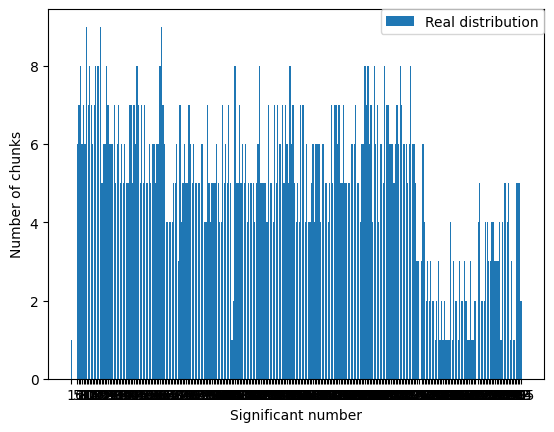

In [184]:
import matplotlib.pyplot as plt
import numpy as np

x = chunks_per_page_sorted_solvency_2
keys = x.keys()
vals = x.values()

plt.bar(keys, vals, label="Real distribution")

# plt.ylim(0,1)
plt.ylabel ('Number of chunks')
plt.xlabel ('Significant number')
plt.xticks(list(keys))
plt.legend (bbox_to_anchor=(1, 1), loc="upper right", borderaxespad=0.)

plt.show()

In [185]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_chroma import Chroma
import warnings
import time

def safe_save_to_vector_store(COLLECTION_NAME, PERSIST_DIRECTORY, embedding_model):
    # In memory vector store for testing only
    # vectorstore = InMemoryVectorStore(embedding_model)
    # create a database with vector embedding and documents.
    vectorstore = Chroma(COLLECTION_NAME, embedding_model, persist_directory=PERSIST_DIRECTORY)
    print(f"Current the vector store has: {vectorstore._collection.count()}")

    print(f"RUNNING FOR COLLECTION_NAME: {COLLECTION_NAME}")

    if vectorstore._collection.count() != 0:
        warnings.warn("You are adding to a non empty collection!")


    # Idea maybe use with retry
    # A lot of people with similar issue on both google forum and https://github.com/langchain-ai/langchain/issues/22241

    # note: behavior of from_documents is to add if vectorstore already exists
    delete_vector_store_check = input("Do you want to delete the vector_store before adding these documents?")
    if delete_vector_store_check == "Y":
        Chroma.delete_collection(Chroma(COLLECTION_NAME, embedding_model, persist_directory=PERSIST_DIRECTORY))

    # Save a new vector store based on config at top of this file (create_vector_store.ipynb)
    check = input("Are you sure you want to run this command? Creating a vectorstore will append to the existing vectorstore and may incur high costs (Y/n)")

    if check == "Y":
        # print("SLEEPING BECAUSE OF GEMINI RATE LIMIT.....")
        # time.sleep(3600)
        print("CREATING A NEW VECTOR STORE AT SPECIFIED LOCATION")
        vectorstore = Chroma.from_documents(chunks, embedding_model, collection_name=COLLECTION_NAME, persist_directory=PERSIST_DIRECTORY)
        print(vectorstore._collection.count())

In [186]:
from langchain_openai import AzureOpenAIEmbeddings

# Set your Azure OpenAI credentials
embedding_api_key = os.getenv("AZURE_OPENAI_API_KEY")
# print(api_key)

# Create an AzureOpenAIEmbeddings object
embedding_model = AzureOpenAIEmbeddings(
    model="text-embedding-3-large",
    azure_endpoint="https://openai-playground-bjorn.openai.azure.com/",
    api_version="2024-02-01",
    api_key=embedding_api_key
)

#config
import os
COLLECTION_NAME = "OPENAI_SOLVENCY_II_V2.2" #name of the collection
PERSIST_DIRECTORY = os.path.join("data", "vector_stores", PROJECT_NAME)

#os.path.join( "data", "solvency-II-files", "solvency II - level 1 - v2.pdf")

safe_save_to_vector_store(COLLECTION_NAME, PERSIST_DIRECTORY, embedding_model)


Current the vector store has: 0
RUNNING FOR COLLECTION_NAME: OPENAI_SOLVENCY_II_V2.2
CREATING A NEW VECTOR STORE AT SPECIFIED LOCATION
3697


In [ ]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
# from langchain_core.documents import Document
import os
import time

model = "gemini-embedding-001"
# model = "gemini-embedding-exp-03-07"
# model = "text-embedding-004"

# from functools import partial

embedding_model = GoogleGenerativeAIEmbeddings(
        model=f"models/{model}", 
        google_api_key=os.environ["GOOGLE_API_KEY"],
        # request_options={'timeout': 10} #{"initial": 70, "multiplier": 2} --> DOES NOT WORK, NOT CONNECTED.
    )

COLLECTION_NAME = "GEMINI_SOLVENCY_II_V2" #name of the collection
PERSIST_DIRECTORY = os.path.join("data", "vector_stores", PROJECT_NAME)




# vectorstore = Chroma(COLLECTION_NAME, embedding_model, persist_directory=PERSIST_DIRECTORY)

# documents = [Document(document) for document in documents_str]

safe_save_to_vector_store(COLLECTION_NAME, PERSIST_DIRECTORY, embedding_model)

Current the vector store has: 0
RUNNING FOR COLLECTION_NAME: GEMINI_SOLVENCY_II_V1
CREATING A NEW VECTOR STORE AT SPECIFIED LOCATION
Sending batch requests 0...
Sending batch requests 1...
Sending batch requests 2...
Sending batch requests 3...
Sending batch requests 4...
Sending batch requests 5...
Sending batch requests 6...
Sending batch requests 7...
Sending batch requests 8...
Sending batch requests 9...
Sending batch requests 10...
Sending batch requests 11...
Sending batch requests 12...
Sending batch requests 13...
Sending batch requests 14...
Sending batch requests 15...
Sending batch requests 16...
Sending batch requests 17...
Sending batch requests 18...
Sending batch requests 19...
Sleeping for 62 s...
total number of batch request: 20
Sending batch requests 0...
Sending batch requests 1...
Sending batch requests 2...
Sending batch requests 3...
Sending batch requests 4...
Sending batch requests 5...
Sending batch requests 6...
Sending batch requests 7...
Sending batch requ

In [ ]:
# import os
# path_other_test = os.path.join("static", "solvency-II-files", "guidelines-level 3-v0.1 - TRUNCATED", "Joint ESA Gls MiCAR %28JC 2024 28%29_EN.pdf")
# # path_other_test = r"static\solvency-II-files\guidelines-level 3-v0.1 - TRUNCATED\Guidelines on operational functioning of colleges.pdf"
# os.path.isfile(path_other_test)

True

In [188]:
from langchain_community.embeddings import DeepInfraEmbeddings

embedding_model = DeepInfraEmbeddings(model_id="Qwen/Qwen3-Embedding-8B", deepinfra_api_token=os.environ["DEEPINFRA_API_KEY"])
COLLECTION_NAME = "QWEN_SOLVENCY_II_V2.2" #name of the collection
PERSIST_DIRECTORY = os.path.join("data", "vector_stores", PROJECT_NAME)


safe_save_to_vector_store(COLLECTION_NAME, PERSIST_DIRECTORY, embedding_model)

Current the vector store has: 0
RUNNING FOR COLLECTION_NAME: QWEN_SOLVENCY_II_V2.2
CREATING A NEW VECTOR STORE AT SPECIFIED LOCATION
3697
